## Test on a simple case
Consider the following Poisson Equation
$$
\begin{cases}
    \Delta u = 0\qquad &u\in\Omega\\
    u = xy\qquad &u\in\partial\Omega.
\end{cases}$$
Here $\Omega = \{(x, y)|\ 0< x, y< 1\}$

The exact solution to this problem is $$u = xy.$$

In [13]:
% matplotlib inline
import torch 
import torch.nn.functional as F
#learning rate decay
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm

torch.set_default_tensor_type('torch.FloatTensor')

class DeepRitzNet(torch.nn.Module):
    def __init__(self, m):
        super(DeepRitzNet, self).__init__()
        self.linear1 = torch.nn.Linear(m,m)
        self.linear2 = torch.nn.Linear(m,m)
        self.linear3 = torch.nn.Linear(m,m)
        self.linear4 = torch.nn.Linear(m,m)
        self.linear5 = torch.nn.Linear(m,m)
        self.linear6 = torch.nn.Linear(m,m)
        self.linear7 = torch.nn.Linear(m,m)
        self.linear8 = torch.nn.Linear(m,m)
        
        self.linear9 = torch.nn.Linear(m,1)
        
        torch.nn.init.constant_(self.linear1.bias, 0.)
        torch.nn.init.constant_(self.linear2.bias, 0.)
        torch.nn.init.constant_(self.linear3.bias, 0.)
        torch.nn.init.constant_(self.linear4.bias, 0.)
        torch.nn.init.constant_(self.linear5.bias, 0.)
        torch.nn.init.constant_(self.linear6.bias, 0.)
        torch.nn.init.constant_(self.linear7.bias, 0.)
        torch.nn.init.constant_(self.linear8.bias, 0.)
        torch.nn.init.constant_(self.linear9.bias, 0.)
        
        torch.nn.init.normal_(self.linear1.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear2.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear3.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear4.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear5.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear6.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear7.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear8.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear9.weight, mean=0, std=0.1)
        
        
        '''
        torch.nn.init.xavier_uniform_(self.linear1.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear2.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear3.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear4.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear5.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear6.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear7.weight, gain=torch.nn.init.calculate_gain('relu'))
        '''
    def forward(self, x):
        y = x
        y = y + F.relu(self.linear2(F.relu(self.linear1(y))))
        y = y + F.relu(self.linear4(F.relu(self.linear3(y))))
        y = y + F.relu(self.linear6(F.relu(self.linear5(y))))
        #y = y + F.relu(self.linear7(F.relu(self.linear8(y))))
        output = F.relu(self.linear9(y))
        return output

In [2]:
def cal_loss(mod):
    points = np.arange(0, 1.1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    mmm = 0
    t = 0
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() - U_groundtruth(re)
            mmm += abs(z[i, j])
            t += 1
    return mmm / t

In [3]:
#相对误差
#余冰的例子里面是
#print(np.linalg.norm(np.reshape(u_solve[:,0]-pu,[-1]),ord=2)/np.linalg.norm(np.reshape(pu,[-1]),ord=2))
def relative_err(mod):
    points = np.arange(0, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    w = np.zeros((xl, yl))
    t = 0
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)
            z[i, j] = mod(re.float()).item() - U_groundtruth(re)
            w[i, j] = U_groundtruth(re)
            t += 1
    z = z ** 2
    w = w ** 2
    return np.sum(z) / np.sum(w)

In [4]:
#U_groundtruth = x * y
#take in a (m,) tensor (x, y, ...)
def U_groundtruth(t):
    return (t[0] * t[1]).item()

In [5]:
def validate(mod):
    draw_graph(mod)
    print(cal_loss(mod))

In [6]:
def draw_graph(mod):
    points = np.arange(0, 1, 0.01)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() - U_groundtruth(re)
    
    plt.imshow(z, cmap=cm.hot)
    plt.colorbar()
    
    my_x_ticks = np.arange(0, 1, 0.2)
    my_y_ticks = np.arange(0, 1, 0.2)
    ax = plt.gca()
    ax.set_xticks(np.linspace(0,99,5))  
    ax.set_xticklabels(('0', '0.25', '0.5', '0.75', '1'))  
    ax.set_yticks(np.linspace(0,99,5))  
    ax.set_yticklabels( ('1', '0.75', '0.5', '0.25', '0'))  
    
    #plt.savefig("../Adaptive/loss_1.eps")
    
    plt.savefig("loss_yubing_2blocks.eps")
    plt.show()

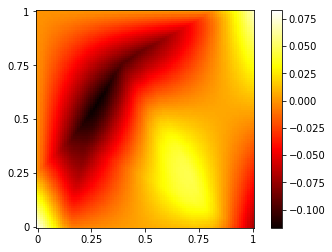

0.02921018591104461


In [23]:
validate(model)

In [22]:
relative_err(model)

0.01982772920459404

In [16]:
#only save the parameters
PATH = 'test_parameters.pkl'
torch.save(model.state_dict(), PATH)

In [21]:
m = 10
PATH = 'test_parameters.pkl'
#从文件读取the_model
model = DeepRitzNet(m)
model.load_state_dict(torch.load(PATH))

In [14]:
model = DeepRitzNet(m)

In [15]:
#训练the_model
train(model, opt='Adam', iterations=50000, milestones=[10000,20000,30000,40000], gamma=0.5, beta=1, 
      beta_increase=1.01, alpha=0, alpha_increase=1, initial_lr=0.00001, print_every_iter=5)

4  epoch, loss:  0.021137502
4  epoch, regularization loss:  0.10594487
4  loss to real solution:  0.19189470369630487
9  epoch, loss:  0.021142526
9  epoch, regularization loss:  0.09622847
9  loss to real solution:  0.19185855944240698
14  epoch, loss:  0.021142516
14  epoch, regularization loss:  0.14313701
14  loss to real solution:  0.19181407834287764
19  epoch, loss:  0.021154266
19  epoch, regularization loss:  0.13331154
19  loss to real solution:  0.1917628391953724
24  epoch, loss:  0.02115857
24  epoch, regularization loss:  0.15076303
24  loss to real solution:  0.19170769198358922
29  epoch, loss:  0.02115511
29  epoch, regularization loss:  0.16618504
29  loss to real solution:  0.1916507198952508
34  epoch, loss:  0.021163322
34  epoch, regularization loss:  0.13063006
34  loss to real solution:  0.19159068684753902
39  epoch, loss:  0.02116069
39  epoch, regularization loss:  0.14863479
39  loss to real solution:  0.19159377077696624
44  epoch, loss:  0.021175299
44  e

339  epoch, loss:  0.022475816
339  epoch, regularization loss:  2.706407
339  loss to real solution:  0.18909708227623595
344  epoch, loss:  0.02254229
344  epoch, regularization loss:  3.0496342
344  loss to real solution:  0.1890294143810776
349  epoch, loss:  0.02256151
349  epoch, regularization loss:  3.7245207
349  loss to real solution:  0.1889638804422676
354  epoch, loss:  0.022597475
354  epoch, regularization loss:  2.25753
354  loss to real solution:  0.18889797720065235
359  epoch, loss:  0.022675872
359  epoch, regularization loss:  3.9885368
359  loss to real solution:  0.18883278245952997
364  epoch, loss:  0.022724504
364  epoch, regularization loss:  4.1123533
364  loss to real solution:  0.18876526747445369
369  epoch, loss:  0.022880897
369  epoch, regularization loss:  4.7655544
369  loss to real solution:  0.18869329834295331
374  epoch, loss:  0.022697993
374  epoch, regularization loss:  3.845868
374  loss to real solution:  0.1886296149651897
379  epoch, loss:

674  epoch, loss:  0.02743145
674  epoch, regularization loss:  47.182632
674  loss to real solution:  0.17149825775811128
679  epoch, loss:  0.027449645
679  epoch, regularization loss:  26.77265
679  loss to real solution:  0.17125674621055814
684  epoch, loss:  0.027764045
684  epoch, regularization loss:  49.671448
684  loss to real solution:  0.17102152374965596
689  epoch, loss:  0.027796106
689  epoch, regularization loss:  38.46971
689  loss to real solution:  0.1707907105200301
694  epoch, loss:  0.027847068
694  epoch, regularization loss:  54.67422
694  loss to real solution:  0.17056895541458217
699  epoch, loss:  0.027830206
699  epoch, regularization loss:  50.921993
699  loss to real solution:  0.17035210228702133
704  epoch, loss:  0.027854746
704  epoch, regularization loss:  44.58057
704  loss to real solution:  0.17013966734990604
709  epoch, loss:  0.02789878
709  epoch, regularization loss:  50.895336
709  loss to real solution:  0.169928894666724
714  epoch, loss:

1009  epoch, loss:  0.028963998
1009  epoch, regularization loss:  52.36867
1009  loss to real solution:  0.16155936390469397
1014  epoch, loss:  0.028985519
1014  epoch, regularization loss:  59.140293
1014  loss to real solution:  0.1614576344315179
1019  epoch, loss:  0.028988047
1019  epoch, regularization loss:  46.166553
1019  loss to real solution:  0.16135025969652605
1024  epoch, loss:  0.029011635
1024  epoch, regularization loss:  44.836903
1024  loss to real solution:  0.16124116078327025
1029  epoch, loss:  0.029020464
1029  epoch, regularization loss:  37.32383
1029  loss to real solution:  0.16113505218516705
1034  epoch, loss:  0.02902729
1034  epoch, regularization loss:  42.08896
1034  loss to real solution:  0.161031263072875
1039  epoch, loss:  0.029025149
1039  epoch, regularization loss:  44.84106
1039  loss to real solution:  0.1609192338801367
1044  epoch, loss:  0.029039355
1044  epoch, regularization loss:  44.591396
1044  loss to real solution:  0.16080510988

1334  epoch, loss:  0.030078307
1334  epoch, regularization loss:  35.409424
1334  loss to real solution:  0.15551778810699132
1339  epoch, loss:  0.030092658
1339  epoch, regularization loss:  38.314186
1339  loss to real solution:  0.15544211828634766
1344  epoch, loss:  0.030121392
1344  epoch, regularization loss:  36.550255
1344  loss to real solution:  0.15536514698473883
1349  epoch, loss:  0.030136313
1349  epoch, regularization loss:  37.189228
1349  loss to real solution:  0.15528930555444126
1354  epoch, loss:  0.030160118
1354  epoch, regularization loss:  34.73069
1354  loss to real solution:  0.1552117302632037
1359  epoch, loss:  0.030184755
1359  epoch, regularization loss:  35.84627
1359  loss to real solution:  0.155132661869457
1364  epoch, loss:  0.030205006
1364  epoch, regularization loss:  32.801018
1364  loss to real solution:  0.15505744490249104
1369  epoch, loss:  0.030220466
1369  epoch, regularization loss:  50.923008
1369  loss to real solution:  0.1549831

1659  epoch, loss:  0.031377908
1659  epoch, regularization loss:  33.609436
1659  loss to real solution:  0.15155992990067188
1664  epoch, loss:  0.031403724
1664  epoch, regularization loss:  41.27911
1664  loss to real solution:  0.15151325225953233
1669  epoch, loss:  0.03141958
1669  epoch, regularization loss:  43.232338
1669  loss to real solution:  0.15146618500228762
1674  epoch, loss:  0.031453654
1674  epoch, regularization loss:  36.93021
1674  loss to real solution:  0.1514212521824463
1679  epoch, loss:  0.03147945
1679  epoch, regularization loss:  39.84006
1679  loss to real solution:  0.15137767506039837
1684  epoch, loss:  0.03150838
1684  epoch, regularization loss:  34.16057
1684  loss to real solution:  0.1513333364089659
1689  epoch, loss:  0.031526826
1689  epoch, regularization loss:  37.585896
1689  loss to real solution:  0.15129071868771368
1694  epoch, loss:  0.031543516
1694  epoch, regularization loss:  33.887306
1694  loss to real solution:  0.15124939786

1989  epoch, loss:  0.03288126
1989  epoch, regularization loss:  43.26745
1989  loss to real solution:  0.14907960540006976
1994  epoch, loss:  0.03290267
1994  epoch, regularization loss:  38.65239
1994  loss to real solution:  0.1490498205649952
1999  epoch, loss:  0.032923967
1999  epoch, regularization loss:  33.639168
1999  loss to real solution:  0.14902070117144553
2004  epoch, loss:  0.03294427
2004  epoch, regularization loss:  28.960974
2004  loss to real solution:  0.14899208096679584
2009  epoch, loss:  0.032974873
2009  epoch, regularization loss:  43.04599
2009  loss to real solution:  0.14896520823117138
2014  epoch, loss:  0.033001952
2014  epoch, regularization loss:  32.81854
2014  loss to real solution:  0.14893614724155307
2019  epoch, loss:  0.033025682
2019  epoch, regularization loss:  34.666553
2019  loss to real solution:  0.1489070969352053
2024  epoch, loss:  0.03304334
2024  epoch, regularization loss:  40.701492
2024  loss to real solution:  0.148879146236

2319  epoch, loss:  0.03445256
2319  epoch, regularization loss:  32.821526
2319  loss to real solution:  0.14740758054758898
2324  epoch, loss:  0.034479566
2324  epoch, regularization loss:  31.617363
2324  loss to real solution:  0.14738477930796057
2329  epoch, loss:  0.034491424
2329  epoch, regularization loss:  33.98661
2329  loss to real solution:  0.14736238070755958
2334  epoch, loss:  0.034501676
2334  epoch, regularization loss:  40.933357
2334  loss to real solution:  0.14734040180267388
2339  epoch, loss:  0.034532286
2339  epoch, regularization loss:  26.530493
2339  loss to real solution:  0.14731790024879557
2344  epoch, loss:  0.034557287
2344  epoch, regularization loss:  32.983074
2344  loss to real solution:  0.14729534438572647
2349  epoch, loss:  0.03458391
2349  epoch, regularization loss:  32.27904
2349  loss to real solution:  0.14727272177530723
2354  epoch, loss:  0.03460472
2354  epoch, regularization loss:  45.540886
2354  loss to real solution:  0.1472499

2649  epoch, loss:  0.036099523
2649  epoch, regularization loss:  32.760845
2649  loss to real solution:  0.14609722450745014
2654  epoch, loss:  0.036134914
2654  epoch, regularization loss:  27.272558
2654  loss to real solution:  0.14607801069159163
2659  epoch, loss:  0.03615502
2659  epoch, regularization loss:  33.946266
2659  loss to real solution:  0.14605893819046423
2664  epoch, loss:  0.03617748
2664  epoch, regularization loss:  26.18819
2664  loss to real solution:  0.14603950098033788
2669  epoch, loss:  0.03618943
2669  epoch, regularization loss:  27.92782
2669  loss to real solution:  0.14602010071523927
2674  epoch, loss:  0.036227044
2674  epoch, regularization loss:  22.015541
2674  loss to real solution:  0.14600071024057304
2679  epoch, loss:  0.036238454
2679  epoch, regularization loss:  37.072784
2679  loss to real solution:  0.1459819945668387
2684  epoch, loss:  0.036261972
2684  epoch, regularization loss:  33.287125
2684  loss to real solution:  0.14596343

2974  epoch, loss:  0.03782637
2974  epoch, regularization loss:  30.883194
2974  loss to real solution:  0.1451960128742802
2979  epoch, loss:  0.037848808
2979  epoch, regularization loss:  34.201283
2979  loss to real solution:  0.14518588667319832
2984  epoch, loss:  0.03787983
2984  epoch, regularization loss:  32.204823
2984  loss to real solution:  0.14517552180723717
2989  epoch, loss:  0.037906904
2989  epoch, regularization loss:  35.876637
2989  loss to real solution:  0.14516676029390546
2994  epoch, loss:  0.03794305
2994  epoch, regularization loss:  34.573895
2994  loss to real solution:  0.14516005975894697
2999  epoch, loss:  0.037973296
2999  epoch, regularization loss:  37.66228
2999  loss to real solution:  0.1451517284088884
3004  epoch, loss:  0.037996646
3004  epoch, regularization loss:  32.43277
3004  loss to real solution:  0.14514183767078342
3009  epoch, loss:  0.03802543
3009  epoch, regularization loss:  30.567446
3009  loss to real solution:  0.1451313542

3304  epoch, loss:  0.039673027
3304  epoch, regularization loss:  22.25853
3304  loss to real solution:  0.14445471390958664
3309  epoch, loss:  0.039697006
3309  epoch, regularization loss:  26.441093
3309  loss to real solution:  0.1444422115890448
3314  epoch, loss:  0.039717976
3314  epoch, regularization loss:  30.634964
3314  loss to real solution:  0.1444289626094921
3319  epoch, loss:  0.039746996
3319  epoch, regularization loss:  32.504513
3319  loss to real solution:  0.14441406852942856
3324  epoch, loss:  0.039766956
3324  epoch, regularization loss:  37.659313
3324  loss to real solution:  0.14439953921993906
3329  epoch, loss:  0.03979017
3329  epoch, regularization loss:  30.752533
3329  loss to real solution:  0.14438600323909573
3334  epoch, loss:  0.039815456
3334  epoch, regularization loss:  29.511156
3334  loss to real solution:  0.14437646212410338
3339  epoch, loss:  0.039852966
3339  epoch, regularization loss:  32.161213
3339  loss to real solution:  0.144369

3634  epoch, loss:  0.04167626
3634  epoch, regularization loss:  29.929144
3634  loss to real solution:  0.14367871574626484
3639  epoch, loss:  0.041715592
3639  epoch, regularization loss:  29.117546
3639  loss to real solution:  0.14367036807881903
3644  epoch, loss:  0.041759387
3644  epoch, regularization loss:  28.211857
3644  loss to real solution:  0.14366634070134363
3649  epoch, loss:  0.0417938
3649  epoch, regularization loss:  26.652483
3649  loss to real solution:  0.14366036718295627
3654  epoch, loss:  0.04180586
3654  epoch, regularization loss:  31.733784
3654  loss to real solution:  0.14364736167113645
3659  epoch, loss:  0.04183892
3659  epoch, regularization loss:  32.032074
3659  loss to real solution:  0.143635229909223
3664  epoch, loss:  0.04186962
3664  epoch, regularization loss:  24.0358
3664  loss to real solution:  0.14362801762405508
3669  epoch, loss:  0.04191159
3669  epoch, regularization loss:  30.612658
3669  loss to real solution:  0.1436171157621

3964  epoch, loss:  0.043735795
3964  epoch, regularization loss:  31.787271
3964  loss to real solution:  0.14269411683082583
3969  epoch, loss:  0.043789614
3969  epoch, regularization loss:  28.068354
3969  loss to real solution:  0.142682318682513
3974  epoch, loss:  0.043797396
3974  epoch, regularization loss:  33.39414
3974  loss to real solution:  0.1426631073296563
3979  epoch, loss:  0.043854866
3979  epoch, regularization loss:  24.910463
3979  loss to real solution:  0.1426419335185004
3984  epoch, loss:  0.043871507
3984  epoch, regularization loss:  24.373312
3984  loss to real solution:  0.14262272462864556
3989  epoch, loss:  0.04389858
3989  epoch, regularization loss:  28.765226
3989  loss to real solution:  0.14260646389043038
3994  epoch, loss:  0.043946046
3994  epoch, regularization loss:  29.541443
3994  loss to real solution:  0.14259253614204978
3999  epoch, loss:  0.04397922
3999  epoch, regularization loss:  26.782103
3999  loss to real solution:  0.142581052

4294  epoch, loss:  0.046108473
4294  epoch, regularization loss:  31.277283
4294  loss to real solution:  0.14130659708799412
4299  epoch, loss:  0.04614313
4299  epoch, regularization loss:  22.578428
4299  loss to real solution:  0.14128773548140017
4304  epoch, loss:  0.04617689
4304  epoch, regularization loss:  23.393068
4304  loss to real solution:  0.14126333680034672
4309  epoch, loss:  0.046229213
4309  epoch, regularization loss:  29.594564
4309  loss to real solution:  0.14124085833711075
4314  epoch, loss:  0.046235
4314  epoch, regularization loss:  32.870438
4314  loss to real solution:  0.14120711096308453
4319  epoch, loss:  0.046288837
4319  epoch, regularization loss:  23.775793
4319  loss to real solution:  0.14117582560570777
4324  epoch, loss:  0.04632934
4324  epoch, regularization loss:  33.220394
4324  loss to real solution:  0.14114671587944033
4329  epoch, loss:  0.046352834
4329  epoch, regularization loss:  27.095707
4329  loss to real solution:  0.14112096

4619  epoch, loss:  0.048586864
4619  epoch, regularization loss:  29.90454
4619  loss to real solution:  0.13945704073699058
4624  epoch, loss:  0.04863495
4624  epoch, regularization loss:  30.695026
4624  loss to real solution:  0.13942944397118473
4629  epoch, loss:  0.0486478
4629  epoch, regularization loss:  28.101896
4629  loss to real solution:  0.13939320453188642
4634  epoch, loss:  0.048700463
4634  epoch, regularization loss:  31.562233
4634  loss to real solution:  0.1393491107644129
4639  epoch, loss:  0.04873814
4639  epoch, regularization loss:  30.85971
4639  loss to real solution:  0.1393048431705838
4644  epoch, loss:  0.04879093
4644  epoch, regularization loss:  22.191252
4644  loss to real solution:  0.13927583331904142
4649  epoch, loss:  0.048816968
4649  epoch, regularization loss:  21.270647
4649  loss to real solution:  0.1392395600750427
4654  epoch, loss:  0.048871975
4654  epoch, regularization loss:  26.289497
4654  loss to real solution:  0.139192554423

4949  epoch, loss:  0.051475625
4949  epoch, regularization loss:  22.784565
4949  loss to real solution:  0.13720082086965077
4954  epoch, loss:  0.051520564
4954  epoch, regularization loss:  27.658716
4954  loss to real solution:  0.13715409790927718
4959  epoch, loss:  0.05155095
4959  epoch, regularization loss:  27.613266
4959  loss to real solution:  0.1371156806837429
4964  epoch, loss:  0.051604226
4964  epoch, regularization loss:  25.157867
4964  loss to real solution:  0.1370808304390632
4969  epoch, loss:  0.051666923
4969  epoch, regularization loss:  29.907322
4969  loss to real solution:  0.13704759838659905
4974  epoch, loss:  0.051703434
4974  epoch, regularization loss:  22.028296
4974  loss to real solution:  0.137017364299987
4979  epoch, loss:  0.051757578
4979  epoch, regularization loss:  30.220331
4979  loss to real solution:  0.13698248215943332
4984  epoch, loss:  0.051784415
4984  epoch, regularization loss:  26.428345
4984  loss to real solution:  0.1369521

5279  epoch, loss:  0.054596614
5279  epoch, regularization loss:  25.68395
5279  loss to real solution:  0.134503440009661
5284  epoch, loss:  0.054614197
5284  epoch, regularization loss:  31.616451
5284  loss to real solution:  0.1344589148474134
5289  epoch, loss:  0.054676
5289  epoch, regularization loss:  27.247961
5289  loss to real solution:  0.1344108227043113
5294  epoch, loss:  0.05473837
5294  epoch, regularization loss:  23.220901
5294  loss to real solution:  0.13436835193190697
5299  epoch, loss:  0.054784786
5299  epoch, regularization loss:  25.488745
5299  loss to real solution:  0.1343397422565902
5304  epoch, loss:  0.054835785
5304  epoch, regularization loss:  23.851677
5304  loss to real solution:  0.13429434100458448
5309  epoch, loss:  0.054895833
5309  epoch, regularization loss:  24.5193
5309  loss to real solution:  0.13425167824118595
5314  epoch, loss:  0.05495635
5314  epoch, regularization loss:  25.69599
5314  loss to real solution:  0.1342168946822813

5609  epoch, loss:  0.0581883
5609  epoch, regularization loss:  23.81539
5609  loss to real solution:  0.13166976081438309
5614  epoch, loss:  0.058224693
5614  epoch, regularization loss:  26.705122
5614  loss to real solution:  0.1316167261654681
5619  epoch, loss:  0.05828822
5619  epoch, regularization loss:  21.506271
5619  loss to real solution:  0.13158098302104262
5624  epoch, loss:  0.058353167
5624  epoch, regularization loss:  22.369026
5624  loss to real solution:  0.13154025066613173
5629  epoch, loss:  0.0583702
5629  epoch, regularization loss:  22.355698
5629  loss to real solution:  0.13148897263013634
5634  epoch, loss:  0.058438722
5634  epoch, regularization loss:  24.217861
5634  loss to real solution:  0.13142974935040994
5639  epoch, loss:  0.05847655
5639  epoch, regularization loss:  26.728014
5639  loss to real solution:  0.13136429827814267
5644  epoch, loss:  0.058529373
5644  epoch, regularization loss:  26.609459
5644  loss to real solution:  0.1313010878

5939  epoch, loss:  0.06213834
5939  epoch, regularization loss:  22.049803
5939  loss to real solution:  0.1284925837149798
5944  epoch, loss:  0.062197033
5944  epoch, regularization loss:  28.849012
5944  loss to real solution:  0.12842538948394056
5949  epoch, loss:  0.062259447
5949  epoch, regularization loss:  19.723717
5949  loss to real solution:  0.1283763106315097
5954  epoch, loss:  0.062321957
5954  epoch, regularization loss:  24.058323
5954  loss to real solution:  0.1283298160837702
5959  epoch, loss:  0.062388815
5959  epoch, regularization loss:  27.235323
5959  loss to real solution:  0.1282923191896648
5964  epoch, loss:  0.062468916
5964  epoch, regularization loss:  26.16268
5964  loss to real solution:  0.1282523348484158
5969  epoch, loss:  0.06254156
5969  epoch, regularization loss:  19.286184
5969  loss to real solution:  0.12821340981347507
5974  epoch, loss:  0.06263181
5974  epoch, regularization loss:  25.906446
5974  loss to real solution:  0.12817344902

6269  epoch, loss:  0.066663906
6269  epoch, regularization loss:  20.526499
6269  loss to real solution:  0.12521423800671402
6274  epoch, loss:  0.06672462
6274  epoch, regularization loss:  26.83951
6274  loss to real solution:  0.12515260369447642
6279  epoch, loss:  0.06680256
6279  epoch, regularization loss:  23.886162
6279  loss to real solution:  0.12509695724761197
6284  epoch, loss:  0.06684603
6284  epoch, regularization loss:  24.045414
6284  loss to real solution:  0.1250403551252421
6289  epoch, loss:  0.06691391
6289  epoch, regularization loss:  21.000515
6289  loss to real solution:  0.12498789023023012
6294  epoch, loss:  0.0669652
6294  epoch, regularization loss:  19.331285
6294  loss to real solution:  0.12492999838772889
6299  epoch, loss:  0.0670353
6299  epoch, regularization loss:  26.107435
6299  loss to real solution:  0.12486970216282148
6304  epoch, loss:  0.06713163
6304  epoch, regularization loss:  22.61427
6304  loss to real solution:  0.12484186851781

6599  epoch, loss:  0.071353406
6599  epoch, regularization loss:  23.59344
6599  loss to real solution:  0.12147812055223742
6604  epoch, loss:  0.07142054
6604  epoch, regularization loss:  23.010372
6604  loss to real solution:  0.12141922006429724
6609  epoch, loss:  0.071509816
6609  epoch, regularization loss:  22.580898
6609  loss to real solution:  0.12136240920252056
6614  epoch, loss:  0.07162757
6614  epoch, regularization loss:  27.853971
6614  loss to real solution:  0.12131903478552492
6619  epoch, loss:  0.071699366
6619  epoch, regularization loss:  21.76108
6619  loss to real solution:  0.12128288984852886
6624  epoch, loss:  0.07179208
6624  epoch, regularization loss:  23.443886
6624  loss to real solution:  0.12125093352326682
6629  epoch, loss:  0.071870096
6629  epoch, regularization loss:  18.68972
6629  loss to real solution:  0.12121478549212468
6634  epoch, loss:  0.071952656
6634  epoch, regularization loss:  23.077087
6634  loss to real solution:  0.12116965

6929  epoch, loss:  0.07650993
6929  epoch, regularization loss:  23.652737
6929  loss to real solution:  0.11761258756079955
6934  epoch, loss:  0.076612055
6934  epoch, regularization loss:  18.6961
6934  loss to real solution:  0.11753187245019708
6939  epoch, loss:  0.07666341
6939  epoch, regularization loss:  21.131733
6939  loss to real solution:  0.11746098779572933
6944  epoch, loss:  0.07673782
6944  epoch, regularization loss:  16.743053
6944  loss to real solution:  0.1173972818988168
6949  epoch, loss:  0.07682152
6949  epoch, regularization loss:  18.204336
6949  loss to real solution:  0.11732258879695062
6954  epoch, loss:  0.07692876
6954  epoch, regularization loss:  20.50349
6954  loss to real solution:  0.1172483792747102
6959  epoch, loss:  0.07692539
6959  epoch, regularization loss:  18.639788
6959  loss to real solution:  0.11716120504951186
6964  epoch, loss:  0.07697305
6964  epoch, regularization loss:  16.922426
6964  loss to real solution:  0.11706633226561

7259  epoch, loss:  0.081964724
7259  epoch, regularization loss:  19.301172
7259  loss to real solution:  0.11358156457404835
7264  epoch, loss:  0.08204112
7264  epoch, regularization loss:  16.84389
7264  loss to real solution:  0.11350996229897667
7269  epoch, loss:  0.08207085
7269  epoch, regularization loss:  15.962125
7269  loss to real solution:  0.11344636369465802
7274  epoch, loss:  0.08219144
7274  epoch, regularization loss:  17.495178
7274  loss to real solution:  0.11339134666406793
7279  epoch, loss:  0.08225826
7279  epoch, regularization loss:  16.307318
7279  loss to real solution:  0.11333412155809179
7284  epoch, loss:  0.08237764
7284  epoch, regularization loss:  15.43307
7284  loss to real solution:  0.1132816967638287
7289  epoch, loss:  0.08249446
7289  epoch, regularization loss:  21.000286
7289  loss to real solution:  0.11325035114564808
7294  epoch, loss:  0.082627565
7294  epoch, regularization loss:  16.497108
7294  loss to real solution:  0.11322114364

7589  epoch, loss:  0.08790354
7589  epoch, regularization loss:  14.104784
7589  loss to real solution:  0.10971589915269667
7594  epoch, loss:  0.08801732
7594  epoch, regularization loss:  15.25527
7594  loss to real solution:  0.10965854042694592
7599  epoch, loss:  0.08812852
7599  epoch, regularization loss:  16.34839
7599  loss to real solution:  0.10958988589750344
7604  epoch, loss:  0.08820261
7604  epoch, regularization loss:  16.087292
7604  loss to real solution:  0.10951708944560579
7609  epoch, loss:  0.08828755
7609  epoch, regularization loss:  19.663605
7609  loss to real solution:  0.10944531170666714
7614  epoch, loss:  0.08840524
7614  epoch, regularization loss:  16.643253
7614  loss to real solution:  0.10937430332484081
7619  epoch, loss:  0.08850216
7619  epoch, regularization loss:  19.691257
7619  loss to real solution:  0.10930009370254094
7624  epoch, loss:  0.088616684
7624  epoch, regularization loss:  18.461985
7624  loss to real solution:  0.10923919816

7919  epoch, loss:  0.09450321
7919  epoch, regularization loss:  16.054876
7919  loss to real solution:  0.10567902948715044
7924  epoch, loss:  0.09466061
7924  epoch, regularization loss:  19.33847
7924  loss to real solution:  0.10564376498961225
7929  epoch, loss:  0.09474891
7929  epoch, regularization loss:  16.616663
7929  loss to real solution:  0.1055760917148153
7934  epoch, loss:  0.09485978
7934  epoch, regularization loss:  18.431612
7934  loss to real solution:  0.10550057277756879
7939  epoch, loss:  0.09497782
7939  epoch, regularization loss:  14.905486
7939  loss to real solution:  0.10543179307519732
7944  epoch, loss:  0.095084816
7944  epoch, regularization loss:  17.395855
7944  loss to real solution:  0.10537186609617918
7949  epoch, loss:  0.09434789
7949  epoch, regularization loss:  14.904033
7949  loss to real solution:  0.10531204201712101
7954  epoch, loss:  0.09443018
7954  epoch, regularization loss:  20.16406
7954  loss to real solution:  0.105236607736

8249  epoch, loss:  0.100323446
8249  epoch, regularization loss:  13.593001
8249  loss to real solution:  0.10142519739294843
8254  epoch, loss:  0.10039996
8254  epoch, regularization loss:  19.611624
8254  loss to real solution:  0.10133537597954276
8259  epoch, loss:  0.10049843
8259  epoch, regularization loss:  14.677318
8259  loss to real solution:  0.10126215242773051
8264  epoch, loss:  0.10055933
8264  epoch, regularization loss:  19.904879
8264  loss to real solution:  0.10118893598013921
8269  epoch, loss:  0.10066175
8269  epoch, regularization loss:  16.051159
8269  loss to real solution:  0.10111148361578463
8274  epoch, loss:  0.100806236
8274  epoch, regularization loss:  12.863431
8274  loss to real solution:  0.10102694284755832
8279  epoch, loss:  0.100754224
8279  epoch, regularization loss:  13.990481
8279  loss to real solution:  0.10092169783947884
8284  epoch, loss:  0.10086836
8284  epoch, regularization loss:  16.432781
8284  loss to real solution:  0.1008384

8579  epoch, loss:  0.107428186
8579  epoch, regularization loss:  12.59271
8579  loss to real solution:  0.09749755979815793
8584  epoch, loss:  0.10759631
8584  epoch, regularization loss:  12.896604
8584  loss to real solution:  0.09745618561575238
8589  epoch, loss:  0.10772112
8589  epoch, regularization loss:  13.020823
8589  loss to real solution:  0.09740686779056701
8594  epoch, loss:  0.10786878
8594  epoch, regularization loss:  14.723307
8594  loss to real solution:  0.09735798463133004
8599  epoch, loss:  0.107906654
8599  epoch, regularization loss:  15.546095
8599  loss to real solution:  0.0972891771802602
8604  epoch, loss:  0.10804453
8604  epoch, regularization loss:  15.172839
8604  loss to real solution:  0.09720668159640773
8609  epoch, loss:  0.108126424
8609  epoch, regularization loss:  16.404419
8609  loss to real solution:  0.09712043080448121
8614  epoch, loss:  0.10822617
8614  epoch, regularization loss:  15.470324
8614  loss to real solution:  0.097033586

8909  epoch, loss:  0.113438025
8909  epoch, regularization loss:  17.095387
8909  loss to real solution:  0.09332963620581906
8914  epoch, loss:  0.11356228
8914  epoch, regularization loss:  13.698862
8914  loss to real solution:  0.09327481484148378
8919  epoch, loss:  0.11371424
8919  epoch, regularization loss:  14.889517
8919  loss to real solution:  0.09323270426000942
8924  epoch, loss:  0.11387733
8924  epoch, regularization loss:  14.088914
8924  loss to real solution:  0.09319254818595642
8929  epoch, loss:  0.113995984
8929  epoch, regularization loss:  12.624077
8929  loss to real solution:  0.09314130807249264
8934  epoch, loss:  0.114126116
8934  epoch, regularization loss:  13.944879
8934  loss to real solution:  0.09307412598713127
8939  epoch, loss:  0.11418304
8939  epoch, regularization loss:  13.430558
8939  loss to real solution:  0.09299419605073114
8944  epoch, loss:  0.11426685
8944  epoch, regularization loss:  14.628995
8944  loss to real solution:  0.0929186

9239  epoch, loss:  0.12126348
9239  epoch, regularization loss:  12.153789
9239  loss to real solution:  0.08927782299443465
9244  epoch, loss:  0.12142958
9244  epoch, regularization loss:  14.905382
9244  loss to real solution:  0.08922583455943373
9249  epoch, loss:  0.12157977
9249  epoch, regularization loss:  14.538757
9249  loss to real solution:  0.08916836991690655
9254  epoch, loss:  0.121710904
9254  epoch, regularization loss:  11.335939
9254  loss to real solution:  0.0891047443677325
9259  epoch, loss:  0.121804066
9259  epoch, regularization loss:  11.35514
9259  loss to real solution:  0.08902970113475955
9264  epoch, loss:  0.12194679
9264  epoch, regularization loss:  13.005799
9264  loss to real solution:  0.08895343931622743
9269  epoch, loss:  0.121862285
9269  epoch, regularization loss:  13.025539
9269  loss to real solution:  0.0888751336217912
9274  epoch, loss:  0.1218305
9274  epoch, regularization loss:  12.57257
9274  loss to real solution:  0.088794627797

9569  epoch, loss:  0.12835558
9569  epoch, regularization loss:  11.340227
9569  loss to real solution:  0.08520937009845392
9574  epoch, loss:  0.12852241
9574  epoch, regularization loss:  13.44311
9574  loss to real solution:  0.08516692405458817
9579  epoch, loss:  0.12865144
9579  epoch, regularization loss:  13.809321
9579  loss to real solution:  0.08510240359678249
9584  epoch, loss:  0.12886673
9584  epoch, regularization loss:  14.657431
9584  loss to real solution:  0.08506122981036497
9589  epoch, loss:  0.12900147
9589  epoch, regularization loss:  10.642984
9589  loss to real solution:  0.08503473591521259
9594  epoch, loss:  0.12901445
9594  epoch, regularization loss:  12.653679
9594  loss to real solution:  0.08494382918004162
9599  epoch, loss:  0.12910998
9599  epoch, regularization loss:  11.934165
9599  loss to real solution:  0.08485909441963208
9604  epoch, loss:  0.12925112
9604  epoch, regularization loss:  10.679466
9604  loss to real solution:  0.08478461870

9899  epoch, loss:  0.13583972
9899  epoch, regularization loss:  13.761113
9899  loss to real solution:  0.08109292249295337
9904  epoch, loss:  0.13604137
9904  epoch, regularization loss:  10.594945
9904  loss to real solution:  0.08106089106152865
9909  epoch, loss:  0.13619488
9909  epoch, regularization loss:  14.014779
9909  loss to real solution:  0.08100541428470415
9914  epoch, loss:  0.13630944
9914  epoch, regularization loss:  13.238773
9914  loss to real solution:  0.08093567244770113
9919  epoch, loss:  0.13636106
9919  epoch, regularization loss:  14.467602
9919  loss to real solution:  0.08087243304333903
9924  epoch, loss:  0.13649775
9924  epoch, regularization loss:  11.784758
9924  loss to real solution:  0.08081206806373496
9929  epoch, loss:  0.13663113
9929  epoch, regularization loss:  14.522773
9929  loss to real solution:  0.08075568669529493
9934  epoch, loss:  0.1368093
9934  epoch, regularization loss:  11.440136
9934  loss to real solution:  0.08069838757

10224  epoch, loss:  0.13993141
10224  epoch, regularization loss:  11.001275
10224  loss to real solution:  0.07838747417446502
10229  epoch, loss:  0.13991494
10229  epoch, regularization loss:  10.330182
10229  loss to real solution:  0.07835216284044517
10234  epoch, loss:  0.13992454
10234  epoch, regularization loss:  11.997114
10234  loss to real solution:  0.07830976035476715
10239  epoch, loss:  0.14000222
10239  epoch, regularization loss:  13.101236
10239  loss to real solution:  0.07828001794489946
10244  epoch, loss:  0.14010967
10244  epoch, regularization loss:  11.184472
10244  loss to real solution:  0.07825876747281098
10249  epoch, loss:  0.14016545
10249  epoch, regularization loss:  11.519623
10249  loss to real solution:  0.07824123667229797
10254  epoch, loss:  0.14024675
10254  epoch, regularization loss:  9.714334
10254  loss to real solution:  0.07821551931544768
10259  epoch, loss:  0.14034337
10259  epoch, regularization loss:  12.697756
10259  loss to real 

10544  epoch, loss:  0.14410041
10544  epoch, regularization loss:  9.89373
10544  loss to real solution:  0.07647113333741001
10549  epoch, loss:  0.14419702
10549  epoch, regularization loss:  10.676073
10549  loss to real solution:  0.07643599438273216
10554  epoch, loss:  0.14425014
10554  epoch, regularization loss:  10.915837
10554  loss to real solution:  0.0763989815608529
10559  epoch, loss:  0.14432935
10559  epoch, regularization loss:  9.753677
10559  loss to real solution:  0.07636370470885896
10564  epoch, loss:  0.14433499
10564  epoch, regularization loss:  11.011533
10564  loss to real solution:  0.07632194197251778
10569  epoch, loss:  0.14440612
10569  epoch, regularization loss:  10.939678
10569  loss to real solution:  0.07626886432882676
10574  epoch, loss:  0.14445817
10574  epoch, regularization loss:  10.842837
10574  loss to real solution:  0.07621813346408617
10579  epoch, loss:  0.1442826
10579  epoch, regularization loss:  9.818665
10579  loss to real solut

10864  epoch, loss:  0.14772068
10864  epoch, regularization loss:  10.054517
10864  loss to real solution:  0.07437792673029682
10869  epoch, loss:  0.14780284
10869  epoch, regularization loss:  10.489614
10869  loss to real solution:  0.07433440265515126
10874  epoch, loss:  0.14783233
10874  epoch, regularization loss:  9.324453
10874  loss to real solution:  0.07429460719535666
10879  epoch, loss:  0.14789042
10879  epoch, regularization loss:  10.721096
10879  loss to real solution:  0.07425113193382901
10884  epoch, loss:  0.14793333
10884  epoch, regularization loss:  11.799706
10884  loss to real solution:  0.07421229455096662
10889  epoch, loss:  0.14799604
10889  epoch, regularization loss:  10.795773
10889  loss to real solution:  0.07417533426799557
10894  epoch, loss:  0.14800292
10894  epoch, regularization loss:  10.914237
10894  loss to real solution:  0.07413930118207104
10899  epoch, loss:  0.1480596
10899  epoch, regularization loss:  9.765393
10899  loss to real so

11184  epoch, loss:  0.1516093
11184  epoch, regularization loss:  10.233904
11184  loss to real solution:  0.07236450276529986
11189  epoch, loss:  0.15167928
11189  epoch, regularization loss:  12.794296
11189  loss to real solution:  0.07233182068575512
11194  epoch, loss:  0.15176427
11194  epoch, regularization loss:  8.906925
11194  loss to real solution:  0.07229936918936485
11199  epoch, loss:  0.1518385
11199  epoch, regularization loss:  9.629316
11199  loss to real solution:  0.07226791942661459
11204  epoch, loss:  0.15191188
11204  epoch, regularization loss:  9.787119
11204  loss to real solution:  0.07223110701611712
11209  epoch, loss:  0.15199554
11209  epoch, regularization loss:  10.600002
11209  loss to real solution:  0.07220530253057637
11214  epoch, loss:  0.15210074
11214  epoch, regularization loss:  10.422269
11214  loss to real solution:  0.07217280409860709
11219  epoch, loss:  0.15217847
11219  epoch, regularization loss:  8.842952
11219  loss to real solut

11504  epoch, loss:  0.15591675
11504  epoch, regularization loss:  11.545154
11504  loss to real solution:  0.07051652172010793
11509  epoch, loss:  0.15605831
11509  epoch, regularization loss:  7.4742036
11509  loss to real solution:  0.07048921546537029
11514  epoch, loss:  0.15612204
11514  epoch, regularization loss:  9.596809
11514  loss to real solution:  0.07045192534027021
11519  epoch, loss:  0.15617308
11519  epoch, regularization loss:  7.8803396
11519  loss to real solution:  0.07041022071537893
11524  epoch, loss:  0.15622503
11524  epoch, regularization loss:  10.686966
11524  loss to real solution:  0.07037570468465652
11529  epoch, loss:  0.15629354
11529  epoch, regularization loss:  10.133752
11529  loss to real solution:  0.07034185255608283
11534  epoch, loss:  0.15635209
11534  epoch, regularization loss:  10.036535
11534  loss to real solution:  0.07030700965422737
11539  epoch, loss:  0.15638414
11539  epoch, regularization loss:  8.350372
11539  loss to real s

11824  epoch, loss:  0.1585454
11824  epoch, regularization loss:  8.409506
11824  loss to real solution:  0.06857247300692333
11829  epoch, loss:  0.15861285
11829  epoch, regularization loss:  9.559329
11829  loss to real solution:  0.0685429030687602
11834  epoch, loss:  0.15863049
11834  epoch, regularization loss:  9.729811
11834  loss to real solution:  0.06851579323842012
11839  epoch, loss:  0.15870276
11839  epoch, regularization loss:  10.090227
11839  loss to real solution:  0.06848667204380035
11844  epoch, loss:  0.15881415
11844  epoch, regularization loss:  7.899022
11844  loss to real solution:  0.06846623166841416
11849  epoch, loss:  0.15898557
11849  epoch, regularization loss:  8.980564
11849  loss to real solution:  0.06843657543282369
11854  epoch, loss:  0.15898916
11854  epoch, regularization loss:  8.715042
11854  loss to real solution:  0.0684037497602711
11859  epoch, loss:  0.15905638
11859  epoch, regularization loss:  10.921133
11859  loss to real solution

12149  epoch, loss:  0.16097552
12149  epoch, regularization loss:  10.058403
12149  loss to real solution:  0.06668910107706204
12154  epoch, loss:  0.16107027
12154  epoch, regularization loss:  9.518435
12154  loss to real solution:  0.06665574830671972
12159  epoch, loss:  0.16113399
12159  epoch, regularization loss:  9.458448
12159  loss to real solution:  0.06662742295417903
12164  epoch, loss:  0.1612036
12164  epoch, regularization loss:  6.7292414
12164  loss to real solution:  0.0665963500922869
12169  epoch, loss:  0.16122948
12169  epoch, regularization loss:  8.901137
12169  loss to real solution:  0.06656446961085657
12174  epoch, loss:  0.16122729
12174  epoch, regularization loss:  7.796906
12174  loss to real solution:  0.06653424334427542
12179  epoch, loss:  0.1612848
12179  epoch, regularization loss:  7.904112
12179  loss to real solution:  0.0665013119011871
12184  epoch, loss:  0.1613063
12184  epoch, regularization loss:  9.317444
12184  loss to real solution: 

12474  epoch, loss:  0.16555482
12474  epoch, regularization loss:  10.210814
12474  loss to real solution:  0.06498076591733074
12479  epoch, loss:  0.16562437
12479  epoch, regularization loss:  9.129162
12479  loss to real solution:  0.0649539964122713
12484  epoch, loss:  0.16575478
12484  epoch, regularization loss:  7.076707
12484  loss to real solution:  0.06492936425403623
12489  epoch, loss:  0.16578366
12489  epoch, regularization loss:  7.1547117
12489  loss to real solution:  0.0648990103731717
12494  epoch, loss:  0.1659127
12494  epoch, regularization loss:  9.65454
12494  loss to real solution:  0.0648682758815525
12499  epoch, loss:  0.1659834
12499  epoch, regularization loss:  9.239627
12499  loss to real solution:  0.06485209662251729
12504  epoch, loss:  0.16611992
12504  epoch, regularization loss:  10.531668
12504  loss to real solution:  0.06483229265479017
12509  epoch, loss:  0.16620296
12509  epoch, regularization loss:  9.135037
12509  loss to real solution: 

12799  epoch, loss:  0.17020354
12799  epoch, regularization loss:  6.1853414
12799  loss to real solution:  0.06330628902458947
12804  epoch, loss:  0.17036262
12804  epoch, regularization loss:  8.037481
12804  loss to real solution:  0.06328684026914194
12809  epoch, loss:  0.17040922
12809  epoch, regularization loss:  6.92518
12809  loss to real solution:  0.06326865140071586
12814  epoch, loss:  0.1704142
12814  epoch, regularization loss:  9.82552
12814  loss to real solution:  0.0632470336950515
12819  epoch, loss:  0.17061539
12819  epoch, regularization loss:  7.8295736
12819  loss to real solution:  0.06322378797595166
12824  epoch, loss:  0.17057836
12824  epoch, regularization loss:  8.690818
12824  loss to real solution:  0.06319626824052865
12829  epoch, loss:  0.17027897
12829  epoch, regularization loss:  7.5125165
12829  loss to real solution:  0.0631681126503905
12834  epoch, loss:  0.17030317
12834  epoch, regularization loss:  7.0788755
12834  loss to real solution

13119  epoch, loss:  0.1735586
13119  epoch, regularization loss:  7.638082
13119  loss to real solution:  0.06170822131978579
13124  epoch, loss:  0.17365101
13124  epoch, regularization loss:  6.982851
13124  loss to real solution:  0.06168562595632451
13129  epoch, loss:  0.17374524
13129  epoch, regularization loss:  8.4070835
13129  loss to real solution:  0.06166229686461204
13134  epoch, loss:  0.17392007
13134  epoch, regularization loss:  9.345761
13134  loss to real solution:  0.061638339153252356
13139  epoch, loss:  0.17397241
13139  epoch, regularization loss:  9.698525
13139  loss to real solution:  0.06161165763893403
13144  epoch, loss:  0.17402266
13144  epoch, regularization loss:  8.377599
13144  loss to real solution:  0.06158759651228416
13149  epoch, loss:  0.17407379
13149  epoch, regularization loss:  7.0976267
13149  loss to real solution:  0.06155992724186133
13154  epoch, loss:  0.17418556
13154  epoch, regularization loss:  8.033536
13154  loss to real solut

13439  epoch, loss:  0.17809248
13439  epoch, regularization loss:  6.747936
13439  loss to real solution:  0.06007295653347141
13444  epoch, loss:  0.17815094
13444  epoch, regularization loss:  8.004941
13444  loss to real solution:  0.060047620279976156
13449  epoch, loss:  0.17827034
13449  epoch, regularization loss:  9.534179
13449  loss to real solution:  0.0600217199990572
13454  epoch, loss:  0.17837013
13454  epoch, regularization loss:  6.1490664
13454  loss to real solution:  0.059995307013515596
13459  epoch, loss:  0.17846178
13459  epoch, regularization loss:  7.5700064
13459  loss to real solution:  0.059968512847650146
13464  epoch, loss:  0.17850003
13464  epoch, regularization loss:  7.1015778
13464  loss to real solution:  0.0599453170351253
13469  epoch, loss:  0.17856225
13469  epoch, regularization loss:  8.421136
13469  loss to real solution:  0.05992041996564747
13474  epoch, loss:  0.17861591
13474  epoch, regularization loss:  8.674156
13474  loss to real sol

13759  epoch, loss:  0.18212208
13759  epoch, regularization loss:  7.0184684
13759  loss to real solution:  0.058495907224406875
13764  epoch, loss:  0.18217678
13764  epoch, regularization loss:  8.365041
13764  loss to real solution:  0.05847214316656767
13769  epoch, loss:  0.18228267
13769  epoch, regularization loss:  6.823226
13769  loss to real solution:  0.058449483611120664
13774  epoch, loss:  0.18233086
13774  epoch, regularization loss:  6.155337
13774  loss to real solution:  0.058427313207841114
13779  epoch, loss:  0.18244131
13779  epoch, regularization loss:  5.948869
13779  loss to real solution:  0.058402262385472775
13784  epoch, loss:  0.18250349
13784  epoch, regularization loss:  7.972744
13784  loss to real solution:  0.058377654934225
13789  epoch, loss:  0.18254969
13789  epoch, regularization loss:  6.759998
13789  loss to real solution:  0.058354661395727106
13794  epoch, loss:  0.18263388
13794  epoch, regularization loss:  6.6543784
13794  loss to real so

14079  epoch, loss:  0.18466797
14079  epoch, regularization loss:  6.8626285
14079  loss to real solution:  0.057193077390105256
14084  epoch, loss:  0.18467088
14084  epoch, regularization loss:  6.664418
14084  loss to real solution:  0.05717873640789472
14089  epoch, loss:  0.18470387
14089  epoch, regularization loss:  7.502827
14089  loss to real solution:  0.05716238136749621
14094  epoch, loss:  0.18480021
14094  epoch, regularization loss:  6.1022396
14094  loss to real solution:  0.0571449018743905
14099  epoch, loss:  0.18495946
14099  epoch, regularization loss:  8.084662
14099  loss to real solution:  0.05712768265900532
14104  epoch, loss:  0.18507712
14104  epoch, regularization loss:  7.115224
14104  loss to real solution:  0.05710727607292576
14109  epoch, loss:  0.18516113
14109  epoch, regularization loss:  6.777799
14109  loss to real solution:  0.0570865132591941
14114  epoch, loss:  0.1852701
14114  epoch, regularization loss:  7.9832816
14114  loss to real soluti

14399  epoch, loss:  0.18830073
14399  epoch, regularization loss:  7.2135925
14399  loss to real solution:  0.05616277988291968
14404  epoch, loss:  0.18835843
14404  epoch, regularization loss:  7.1986933
14404  loss to real solution:  0.056152163513682095
14409  epoch, loss:  0.18843761
14409  epoch, regularization loss:  7.4871354
14409  loss to real solution:  0.05613860247179495
14414  epoch, loss:  0.18852706
14414  epoch, regularization loss:  6.844545
14414  loss to real solution:  0.05612677972425113
14419  epoch, loss:  0.18857102
14419  epoch, regularization loss:  6.6462226
14419  loss to real solution:  0.05611135668375274
14424  epoch, loss:  0.18862846
14424  epoch, regularization loss:  7.407906
14424  loss to real solution:  0.056096122278408565
14429  epoch, loss:  0.18873462
14429  epoch, regularization loss:  8.157389
14429  loss to real solution:  0.056082482697549924
14434  epoch, loss:  0.18885645
14434  epoch, regularization loss:  6.903498
14434  loss to real 

14719  epoch, loss:  0.19256361
14719  epoch, regularization loss:  6.3511376
14719  loss to real solution:  0.05532255489471529
14724  epoch, loss:  0.19268881
14724  epoch, regularization loss:  6.545225
14724  loss to real solution:  0.055307868722795445
14729  epoch, loss:  0.19282043
14729  epoch, regularization loss:  5.9185696
14729  loss to real solution:  0.05530510705118336
14734  epoch, loss:  0.1927799
14734  epoch, regularization loss:  6.0298257
14734  loss to real solution:  0.05530324055759374
14739  epoch, loss:  0.19266851
14739  epoch, regularization loss:  7.153947
14739  loss to real solution:  0.055293891525958185
14744  epoch, loss:  0.19267844
14744  epoch, regularization loss:  6.4160547
14744  loss to real solution:  0.055280640729941606
14749  epoch, loss:  0.19284815
14749  epoch, regularization loss:  5.958186
14749  loss to real solution:  0.05526503785952063
14754  epoch, loss:  0.19258386
14754  epoch, regularization loss:  7.217477
14754  loss to real s

15039  epoch, loss:  0.19693708
15039  epoch, regularization loss:  6.471685
15039  loss to real solution:  0.0543291686499907
15044  epoch, loss:  0.19694534
15044  epoch, regularization loss:  6.432098
15044  loss to real solution:  0.05431709507649595
15049  epoch, loss:  0.19704594
15049  epoch, regularization loss:  6.369206
15049  loss to real solution:  0.054309530674426024
15054  epoch, loss:  0.19712502
15054  epoch, regularization loss:  5.9514055
15054  loss to real solution:  0.05430155572073519
15059  epoch, loss:  0.1972201
15059  epoch, regularization loss:  6.495
15059  loss to real solution:  0.054295501816124955
15064  epoch, loss:  0.19718614
15064  epoch, regularization loss:  6.086354
15064  loss to real solution:  0.0542915120302153
15069  epoch, loss:  0.19726515
15069  epoch, regularization loss:  7.734705
15069  loss to real solution:  0.05428244759844354
15074  epoch, loss:  0.19735423
15074  epoch, regularization loss:  6.4963565
15074  loss to real solution:

15359  epoch, loss:  0.20150779
15359  epoch, regularization loss:  6.4405274
15359  loss to real solution:  0.05352675080053078
15364  epoch, loss:  0.20160374
15364  epoch, regularization loss:  5.3981953
15364  loss to real solution:  0.053511565562861026
15369  epoch, loss:  0.20167387
15369  epoch, regularization loss:  4.944318
15369  loss to real solution:  0.0534962570827362
15374  epoch, loss:  0.20179237
15374  epoch, regularization loss:  4.792643
15374  loss to real solution:  0.05348471173077576
15379  epoch, loss:  0.20196119
15379  epoch, regularization loss:  6.9651146
15379  loss to real solution:  0.05347498986223513
15384  epoch, loss:  0.20192768
15384  epoch, regularization loss:  6.0523725
15384  loss to real solution:  0.05346529530222751
15389  epoch, loss:  0.20201269
15389  epoch, regularization loss:  6.239823
15389  loss to real solution:  0.05345492985130342
15394  epoch, loss:  0.20220128
15394  epoch, regularization loss:  6.4614205
15394  loss to real so

15679  epoch, loss:  0.20596874
15679  epoch, regularization loss:  7.122442
15679  loss to real solution:  0.05279015294407026
15684  epoch, loss:  0.20610467
15684  epoch, regularization loss:  5.8689322
15684  loss to real solution:  0.05277556024307063
15689  epoch, loss:  0.20622283
15689  epoch, regularization loss:  5.997747
15689  loss to real solution:  0.05276131297808049
15694  epoch, loss:  0.20627385
15694  epoch, regularization loss:  4.890781
15694  loss to real solution:  0.05275753765805695
15699  epoch, loss:  0.20632777
15699  epoch, regularization loss:  5.905376
15699  loss to real solution:  0.052754529255234515
15704  epoch, loss:  0.20635924
15704  epoch, regularization loss:  6.4837484
15704  loss to real solution:  0.05275757949830088
15709  epoch, loss:  0.20638335
15709  epoch, regularization loss:  5.885815
15709  loss to real solution:  0.05275725321213077
15714  epoch, loss:  0.2065215
15714  epoch, regularization loss:  6.2543225
15714  loss to real solu

15999  epoch, loss:  0.21010254
15999  epoch, regularization loss:  5.587461
15999  loss to real solution:  0.05204975944535793
16004  epoch, loss:  0.210149
16004  epoch, regularization loss:  5.46781
16004  loss to real solution:  0.05204198070055199
16009  epoch, loss:  0.21028204
16009  epoch, regularization loss:  5.2896376
16009  loss to real solution:  0.05203150573840813
16014  epoch, loss:  0.21028218
16014  epoch, regularization loss:  6.162305
16014  loss to real solution:  0.05201624999731042
16019  epoch, loss:  0.21039736
16019  epoch, regularization loss:  5.1588526
16019  loss to real solution:  0.05199602376454135
16024  epoch, loss:  0.21055813
16024  epoch, regularization loss:  5.768799
16024  loss to real solution:  0.05197473317631022
16029  epoch, loss:  0.21062018
16029  epoch, regularization loss:  5.9294343
16029  loss to real solution:  0.05195337045291241
16034  epoch, loss:  0.21072379
16034  epoch, regularization loss:  5.685537
16034  loss to real solutio

16319  epoch, loss:  0.21433058
16319  epoch, regularization loss:  5.2758365
16319  loss to real solution:  0.05141036080181107
16324  epoch, loss:  0.2144276
16324  epoch, regularization loss:  6.2211943
16324  loss to real solution:  0.05139870144365249
16329  epoch, loss:  0.2146093
16329  epoch, regularization loss:  5.7444654
16329  loss to real solution:  0.05139809286668282
16334  epoch, loss:  0.21467659
16334  epoch, regularization loss:  5.3391223
16334  loss to real solution:  0.051401113584514505
16339  epoch, loss:  0.21469091
16339  epoch, regularization loss:  5.72516
16339  loss to real solution:  0.05139913677922952
16344  epoch, loss:  0.21474926
16344  epoch, regularization loss:  6.456114
16344  loss to real solution:  0.051395378515493785
16349  epoch, loss:  0.21486205
16349  epoch, regularization loss:  5.3404045
16349  loss to real solution:  0.05138566301997044
16354  epoch, loss:  0.2150687
16354  epoch, regularization loss:  5.804471
16354  loss to real solu

16639  epoch, loss:  0.21692315
16639  epoch, regularization loss:  4.583141
16639  loss to real solution:  0.05097983185047947
16644  epoch, loss:  0.21701717
16644  epoch, regularization loss:  5.8353586
16644  loss to real solution:  0.050973400644773306
16649  epoch, loss:  0.21713543
16649  epoch, regularization loss:  5.155121
16649  loss to real solution:  0.050958271070945374
16654  epoch, loss:  0.21717516
16654  epoch, regularization loss:  4.313042
16654  loss to real solution:  0.050956708142333794
16659  epoch, loss:  0.21718182
16659  epoch, regularization loss:  4.2901692
16659  loss to real solution:  0.0509557839008895
16664  epoch, loss:  0.21727882
16664  epoch, regularization loss:  4.8378987
16664  loss to real solution:  0.050954349818062204
16669  epoch, loss:  0.21739987
16669  epoch, regularization loss:  4.6118283
16669  loss to real solution:  0.05094147746227991
16674  epoch, loss:  0.2174945
16674  epoch, regularization loss:  4.943815
16674  loss to real s

16959  epoch, loss:  0.21855211
16959  epoch, regularization loss:  5.0794435
16959  loss to real solution:  0.05086571901051468
16964  epoch, loss:  0.21865988
16964  epoch, regularization loss:  4.026906
16964  loss to real solution:  0.05086408493193715
16969  epoch, loss:  0.21872999
16969  epoch, regularization loss:  5.728847
16969  loss to real solution:  0.050862429302093434
16974  epoch, loss:  0.21882448
16974  epoch, regularization loss:  4.8239307
16974  loss to real solution:  0.05085376008975607
16979  epoch, loss:  0.21890123
16979  epoch, regularization loss:  4.8829575
16979  loss to real solution:  0.05084750501946972
16984  epoch, loss:  0.21899624
16984  epoch, regularization loss:  4.964099
16984  loss to real solution:  0.05084528413070137
16989  epoch, loss:  0.21912801
16989  epoch, regularization loss:  5.5339375
16989  loss to real solution:  0.050845894524134905
16994  epoch, loss:  0.21913987
16994  epoch, regularization loss:  4.5658207
16994  loss to real 

17279  epoch, loss:  0.22289467
17279  epoch, regularization loss:  2.9174323
17279  loss to real solution:  0.05038507416474921
17284  epoch, loss:  0.22298568
17284  epoch, regularization loss:  5.363308
17284  loss to real solution:  0.05038485280245792
17289  epoch, loss:  0.22302057
17289  epoch, regularization loss:  4.8389263
17289  loss to real solution:  0.050397702406260625
17294  epoch, loss:  0.22316842
17294  epoch, regularization loss:  5.105573
17294  loss to real solution:  0.05041449404452461
17299  epoch, loss:  0.22323665
17299  epoch, regularization loss:  4.0523
17299  loss to real solution:  0.050409723487028435
17304  epoch, loss:  0.22327642
17304  epoch, regularization loss:  4.907141
17304  loss to real solution:  0.05040325071816605
17309  epoch, loss:  0.22342919
17309  epoch, regularization loss:  4.526004
17309  loss to real solution:  0.0503910918016572
17314  epoch, loss:  0.22349288
17314  epoch, regularization loss:  4.8286657
17314  loss to real solut

17599  epoch, loss:  0.22855307
17599  epoch, regularization loss:  3.7220254
17599  loss to real solution:  0.04990180995715554
17604  epoch, loss:  0.22871056
17604  epoch, regularization loss:  3.8166053
17604  loss to real solution:  0.04987804294371411
17609  epoch, loss:  0.22886887
17609  epoch, regularization loss:  5.26067
17609  loss to real solution:  0.049859996313644864
17614  epoch, loss:  0.22895052
17614  epoch, regularization loss:  4.2831964
17614  loss to real solution:  0.04985686346765395
17619  epoch, loss:  0.22907968
17619  epoch, regularization loss:  4.0286875
17619  loss to real solution:  0.04986551005116182
17624  epoch, loss:  0.2291031
17624  epoch, regularization loss:  4.1237674
17624  loss to real solution:  0.04987831710660756
17629  epoch, loss:  0.22904474
17629  epoch, regularization loss:  4.128694
17629  loss to real solution:  0.04989435463528006
17634  epoch, loss:  0.22921015
17634  epoch, regularization loss:  5.287138
17634  loss to real sol

17919  epoch, loss:  0.23280874
17919  epoch, regularization loss:  3.8494399
17919  loss to real solution:  0.049909947700490655
17924  epoch, loss:  0.23294367
17924  epoch, regularization loss:  4.5726132
17924  loss to real solution:  0.04990682661533357
17929  epoch, loss:  0.23299211
17929  epoch, regularization loss:  4.469443
17929  loss to real solution:  0.04991865826047158
17934  epoch, loss:  0.23309381
17934  epoch, regularization loss:  4.2860994
17934  loss to real solution:  0.049914576573805394
17939  epoch, loss:  0.23324053
17939  epoch, regularization loss:  4.585484
17939  loss to real solution:  0.04990721413788718
17944  epoch, loss:  0.23337275
17944  epoch, regularization loss:  4.595051
17944  loss to real solution:  0.0498912011160831
17949  epoch, loss:  0.23351
17949  epoch, regularization loss:  4.4947186
17949  loss to real solution:  0.049889236595019835
17954  epoch, loss:  0.23358537
17954  epoch, regularization loss:  3.2267637
17954  loss to real sol

18239  epoch, loss:  0.23579891
18239  epoch, regularization loss:  3.5302174
18239  loss to real solution:  0.04971721457302079
18244  epoch, loss:  0.23590045
18244  epoch, regularization loss:  4.7192593
18244  loss to real solution:  0.04970100460343126
18249  epoch, loss:  0.23602958
18249  epoch, regularization loss:  4.1362624
18249  loss to real solution:  0.049677917932675904
18254  epoch, loss:  0.23620386
18254  epoch, regularization loss:  3.9717069
18254  loss to real solution:  0.049656145735220494
18259  epoch, loss:  0.2362122
18259  epoch, regularization loss:  3.7290692
18259  loss to real solution:  0.04965394544330512
18264  epoch, loss:  0.23616348
18264  epoch, regularization loss:  3.691801
18264  loss to real solution:  0.049654062805343284
18269  epoch, loss:  0.23632357
18269  epoch, regularization loss:  4.41587
18269  loss to real solution:  0.04965175195543236
18274  epoch, loss:  0.23643598
18274  epoch, regularization loss:  3.1793218
18274  loss to real 

18559  epoch, loss:  0.24231902
18559  epoch, regularization loss:  3.8009214
18559  loss to real solution:  0.049441026885154844
18564  epoch, loss:  0.24245687
18564  epoch, regularization loss:  3.8795104
18564  loss to real solution:  0.04942523340917818
18569  epoch, loss:  0.2426112
18569  epoch, regularization loss:  4.481796
18569  loss to real solution:  0.04941138955310359
18574  epoch, loss:  0.24273592
18574  epoch, regularization loss:  4.18516
18574  loss to real solution:  0.04939207801764664
18579  epoch, loss:  0.24285412
18579  epoch, regularization loss:  3.9949496
18579  loss to real solution:  0.049397130250191906
18584  epoch, loss:  0.24293281
18584  epoch, regularization loss:  3.816531
18584  loss to real solution:  0.049400857480104324
18589  epoch, loss:  0.24302687
18589  epoch, regularization loss:  3.9096427
18589  loss to real solution:  0.04938860032060917
18594  epoch, loss:  0.24315189
18594  epoch, regularization loss:  3.729861
18594  loss to real so

18879  epoch, loss:  0.24851638
18879  epoch, regularization loss:  4.554285
18879  loss to real solution:  0.04920462436543026
18884  epoch, loss:  0.24860807
18884  epoch, regularization loss:  3.610227
18884  loss to real solution:  0.049194978942309564
18889  epoch, loss:  0.24870062
18889  epoch, regularization loss:  3.5019176
18889  loss to real solution:  0.04919292384435326
18894  epoch, loss:  0.2488363
18894  epoch, regularization loss:  3.2428067
18894  loss to real solution:  0.049187878200337945
18899  epoch, loss:  0.24897148
18899  epoch, regularization loss:  3.3586478
18899  loss to real solution:  0.04917421980830267
18904  epoch, loss:  0.24914426
18904  epoch, regularization loss:  4.055651
18904  loss to real solution:  0.04914781137931449
18909  epoch, loss:  0.24932949
18909  epoch, regularization loss:  3.9283226
18909  loss to real solution:  0.049136789846272545
18914  epoch, loss:  0.24946286
18914  epoch, regularization loss:  3.436211
18914  loss to real s

19199  epoch, loss:  0.24883188
19199  epoch, regularization loss:  3.4957647
19199  loss to real solution:  0.04943451654566224
19204  epoch, loss:  0.24890774
19204  epoch, regularization loss:  3.6944644
19204  loss to real solution:  0.04942838225482912
19209  epoch, loss:  0.24901895
19209  epoch, regularization loss:  3.478481
19209  loss to real solution:  0.049409784158645616
19214  epoch, loss:  0.24907269
19214  epoch, regularization loss:  3.5542738
19214  loss to real solution:  0.04940877725270172
19219  epoch, loss:  0.24920191
19219  epoch, regularization loss:  3.4785037
19219  loss to real solution:  0.04940759128652333
19224  epoch, loss:  0.24929948
19224  epoch, regularization loss:  3.6020427
19224  loss to real solution:  0.0493982007533066
19229  epoch, loss:  0.24941601
19229  epoch, regularization loss:  4.2647343
19229  loss to real solution:  0.04939022099676216
19234  epoch, loss:  0.24955948
19234  epoch, regularization loss:  3.0675402
19234  loss to real 

19519  epoch, loss:  0.25149262
19519  epoch, regularization loss:  3.1789434
19519  loss to real solution:  0.04932000756386888
19524  epoch, loss:  0.25155947
19524  epoch, regularization loss:  3.1924896
19524  loss to real solution:  0.0493093998459253
19529  epoch, loss:  0.25176176
19529  epoch, regularization loss:  3.514597
19529  loss to real solution:  0.04929949913266282
19534  epoch, loss:  0.25162345
19534  epoch, regularization loss:  3.5194585
19534  loss to real solution:  0.04929487416936352
19539  epoch, loss:  0.25177702
19539  epoch, regularization loss:  3.9087045
19539  loss to real solution:  0.04928770726500469
19544  epoch, loss:  0.25179243
19544  epoch, regularization loss:  3.1472235
19544  loss to real solution:  0.04929086720401596
19549  epoch, loss:  0.25200522
19549  epoch, regularization loss:  3.1013892
19549  loss to real solution:  0.04928954047728181
19554  epoch, loss:  0.25207397
19554  epoch, regularization loss:  3.8780177
19554  loss to real s

19839  epoch, loss:  0.25455886
19839  epoch, regularization loss:  3.099108
19839  loss to real solution:  0.04939474516909975
19844  epoch, loss:  0.25460893
19844  epoch, regularization loss:  3.8526022
19844  loss to real solution:  0.04941432430970773
19849  epoch, loss:  0.2547099
19849  epoch, regularization loss:  3.0906992
19849  loss to real solution:  0.04942460380186725
19854  epoch, loss:  0.2548947
19854  epoch, regularization loss:  2.9679961
19854  loss to real solution:  0.04941130510046468
19859  epoch, loss:  0.2549599
19859  epoch, regularization loss:  3.0972595
19859  loss to real solution:  0.049407309895950956
19864  epoch, loss:  0.2550893
19864  epoch, regularization loss:  3.1218808
19864  loss to real solution:  0.049416209245023705
19869  epoch, loss:  0.25511992
19869  epoch, regularization loss:  2.7906961
19869  loss to real solution:  0.049425121063043316
19874  epoch, loss:  0.25539166
19874  epoch, regularization loss:  2.8638518
19874  loss to real s

20159  epoch, loss:  0.2571747
20159  epoch, regularization loss:  3.747999
20159  loss to real solution:  0.04930296202090166
20164  epoch, loss:  0.25719374
20164  epoch, regularization loss:  3.2815642
20164  loss to real solution:  0.049289870550317263
20169  epoch, loss:  0.2572462
20169  epoch, regularization loss:  2.8936932
20169  loss to real solution:  0.049292099566991716
20174  epoch, loss:  0.25733024
20174  epoch, regularization loss:  2.9466512
20174  loss to real solution:  0.04929371849810787
20179  epoch, loss:  0.25736257
20179  epoch, regularization loss:  2.0950208
20179  loss to real solution:  0.04929241938778197
20184  epoch, loss:  0.25743768
20184  epoch, regularization loss:  2.299036
20184  loss to real solution:  0.04928235371497057
20189  epoch, loss:  0.25751927
20189  epoch, regularization loss:  3.0242376
20189  loss to real solution:  0.049269162554386285
20194  epoch, loss:  0.25762975
20194  epoch, regularization loss:  2.3122783
20194  loss to real 

20479  epoch, loss:  0.2606678
20479  epoch, regularization loss:  2.8222983
20479  loss to real solution:  0.04925176477136696
20484  epoch, loss:  0.26071995
20484  epoch, regularization loss:  2.7941368
20484  loss to real solution:  0.0492429178534461
20489  epoch, loss:  0.26081216
20489  epoch, regularization loss:  3.0526643
20489  loss to real solution:  0.04922714306549598
20494  epoch, loss:  0.26100025
20494  epoch, regularization loss:  2.4552717
20494  loss to real solution:  0.04921656533459992
20499  epoch, loss:  0.26093268
20499  epoch, regularization loss:  2.0920796
20499  loss to real solution:  0.049201974881089475
20504  epoch, loss:  0.2610431
20504  epoch, regularization loss:  2.7276223
20504  loss to real solution:  0.049196671545505576
20509  epoch, loss:  0.2610881
20509  epoch, regularization loss:  3.087387
20509  loss to real solution:  0.049199278448238896
20514  epoch, loss:  0.26119626
20514  epoch, regularization loss:  2.691405
20514  loss to real so

20799  epoch, loss:  0.26399034
20799  epoch, regularization loss:  3.0325549
20799  loss to real solution:  0.04935442798393822
20804  epoch, loss:  0.2640499
20804  epoch, regularization loss:  2.4076176
20804  loss to real solution:  0.049357377798104146
20809  epoch, loss:  0.26408994
20809  epoch, regularization loss:  2.7102382
20809  loss to real solution:  0.04936882379872745
20814  epoch, loss:  0.26414108
20814  epoch, regularization loss:  2.213587
20814  loss to real solution:  0.04937494294209919
20819  epoch, loss:  0.26416788
20819  epoch, regularization loss:  2.908195
20819  loss to real solution:  0.04937709554414124
20824  epoch, loss:  0.2643386
20824  epoch, regularization loss:  2.4018018
20824  loss to real solution:  0.049388020804598365
20829  epoch, loss:  0.26421434
20829  epoch, regularization loss:  3.0737972
20829  loss to real solution:  0.04939308375120168
20834  epoch, loss:  0.26427457
20834  epoch, regularization loss:  2.8838549
20834  loss to real s

21119  epoch, loss:  0.26794386
21119  epoch, regularization loss:  2.2312863
21119  loss to real solution:  0.0491864155442262
21124  epoch, loss:  0.2679755
21124  epoch, regularization loss:  2.342827
21124  loss to real solution:  0.04919605604134321
21129  epoch, loss:  0.2679764
21129  epoch, regularization loss:  2.26543
21129  loss to real solution:  0.04919785440214415
21134  epoch, loss:  0.26805547
21134  epoch, regularization loss:  3.276984
21134  loss to real solution:  0.049192016779883885
21139  epoch, loss:  0.26813096
21139  epoch, regularization loss:  3.576945
21139  loss to real solution:  0.049188104670895086
21144  epoch, loss:  0.2682282
21144  epoch, regularization loss:  2.5336978
21144  loss to real solution:  0.0491813457012177
21149  epoch, loss:  0.26821825
21149  epoch, regularization loss:  2.799168
21149  loss to real solution:  0.049171170917424345
21154  epoch, loss:  0.26828974
21154  epoch, regularization loss:  3.053246
21154  loss to real solution

21439  epoch, loss:  0.27037105
21439  epoch, regularization loss:  2.5407648
21439  loss to real solution:  0.04927975241556646
21444  epoch, loss:  0.27032462
21444  epoch, regularization loss:  2.1325297
21444  loss to real solution:  0.04927874818813708
21449  epoch, loss:  0.27035302
21449  epoch, regularization loss:  2.4302902
21449  loss to real solution:  0.04928355664507422
21454  epoch, loss:  0.27043256
21454  epoch, regularization loss:  2.449548
21454  loss to real solution:  0.0492886786421469
21459  epoch, loss:  0.27045372
21459  epoch, regularization loss:  2.232384
21459  loss to real solution:  0.04928506092345424
21464  epoch, loss:  0.2705293
21464  epoch, regularization loss:  2.726518
21464  loss to real solution:  0.04927399761174341
21469  epoch, loss:  0.27063128
21469  epoch, regularization loss:  2.513671
21469  loss to real solution:  0.04927121497382808
21474  epoch, loss:  0.270628
21474  epoch, regularization loss:  2.3742604
21474  loss to real solutio

21759  epoch, loss:  0.2723502
21759  epoch, regularization loss:  2.3675556
21759  loss to real solution:  0.04925435494785471
21764  epoch, loss:  0.27245635
21764  epoch, regularization loss:  1.9617206
21764  loss to real solution:  0.04925817654152552
21769  epoch, loss:  0.27255014
21769  epoch, regularization loss:  2.937951
21769  loss to real solution:  0.04925420316536569
21774  epoch, loss:  0.27262005
21774  epoch, regularization loss:  2.6688974
21774  loss to real solution:  0.04923226120550775
21779  epoch, loss:  0.27278128
21779  epoch, regularization loss:  2.486466
21779  loss to real solution:  0.04921597288167186
21784  epoch, loss:  0.27283782
21784  epoch, regularization loss:  2.9918237
21784  loss to real solution:  0.04919542966056466
21789  epoch, loss:  0.27289543
21789  epoch, regularization loss:  2.663191
21789  loss to real solution:  0.049187469792760154
21794  epoch, loss:  0.27282506
21794  epoch, regularization loss:  2.1900249
21794  loss to real so

22079  epoch, loss:  0.2748718
22079  epoch, regularization loss:  2.7470686
22079  loss to real solution:  0.04922457528508404
22084  epoch, loss:  0.27460665
22084  epoch, regularization loss:  2.1865788
22084  loss to real solution:  0.049230973548140454
22089  epoch, loss:  0.274665
22089  epoch, regularization loss:  2.1920352
22089  loss to real solution:  0.04923405636440629
22094  epoch, loss:  0.27473637
22094  epoch, regularization loss:  2.4791112
22094  loss to real solution:  0.049237200878868466
22099  epoch, loss:  0.274823
22099  epoch, regularization loss:  2.625705
22099  loss to real solution:  0.04923298021732288
22104  epoch, loss:  0.2748803
22104  epoch, regularization loss:  2.2791522
22104  loss to real solution:  0.04923431738102736
22109  epoch, loss:  0.27494708
22109  epoch, regularization loss:  2.4651477
22109  loss to real solution:  0.04923454280727171
22114  epoch, loss:  0.27492952
22114  epoch, regularization loss:  2.3360596
22114  loss to real solu

22399  epoch, loss:  0.27570662
22399  epoch, regularization loss:  2.1180222
22399  loss to real solution:  0.049330610408763305
22404  epoch, loss:  0.2757299
22404  epoch, regularization loss:  2.1885138
22404  loss to real solution:  0.0493303975438284
22409  epoch, loss:  0.27591872
22409  epoch, regularization loss:  1.8922508
22409  loss to real solution:  0.049329419978394046
22414  epoch, loss:  0.2759083
22414  epoch, regularization loss:  1.9937181
22414  loss to real solution:  0.04933199972653197
22419  epoch, loss:  0.27601132
22419  epoch, regularization loss:  2.4932337
22419  loss to real solution:  0.049324513001382894
22424  epoch, loss:  0.27611724
22424  epoch, regularization loss:  2.6085963
22424  loss to real solution:  0.04932442020778818
22429  epoch, loss:  0.27611056
22429  epoch, regularization loss:  2.4707568
22429  loss to real solution:  0.04932996553330387
22434  epoch, loss:  0.2761395
22434  epoch, regularization loss:  2.154701
22434  loss to real s

22719  epoch, loss:  0.27784392
22719  epoch, regularization loss:  2.3200011
22719  loss to real solution:  0.049444699548492795
22724  epoch, loss:  0.27786463
22724  epoch, regularization loss:  2.2505167
22724  loss to real solution:  0.04945618206311853
22729  epoch, loss:  0.27796358
22729  epoch, regularization loss:  2.2255325
22729  loss to real solution:  0.04946311307347515
22734  epoch, loss:  0.27798373
22734  epoch, regularization loss:  1.8540888
22734  loss to real solution:  0.04945976671601135
22739  epoch, loss:  0.27801466
22739  epoch, regularization loss:  1.7637205
22739  loss to real solution:  0.04945875645422743
22744  epoch, loss:  0.27812266
22744  epoch, regularization loss:  2.4814525
22744  loss to real solution:  0.04946924317720513
22749  epoch, loss:  0.27816918
22749  epoch, regularization loss:  2.09259
22749  loss to real solution:  0.049470449062910996
22754  epoch, loss:  0.27824372
22754  epoch, regularization loss:  2.0648718
22754  loss to real

23039  epoch, loss:  0.28161305
23039  epoch, regularization loss:  1.9342757
23039  loss to real solution:  0.04940028442085287
23044  epoch, loss:  0.28161353
23044  epoch, regularization loss:  2.2072644
23044  loss to real solution:  0.04939939755546165
23049  epoch, loss:  0.28168866
23049  epoch, regularization loss:  1.6145748
23049  loss to real solution:  0.049402238443370744
23054  epoch, loss:  0.28172892
23054  epoch, regularization loss:  2.3355742
23054  loss to real solution:  0.049397831209435
23059  epoch, loss:  0.28171882
23059  epoch, regularization loss:  2.1111224
23059  loss to real solution:  0.04939724113330373
23064  epoch, loss:  0.28177947
23064  epoch, regularization loss:  2.086139
23064  loss to real solution:  0.049389059595332706
23069  epoch, loss:  0.28190613
23069  epoch, regularization loss:  2.618651
23069  loss to real solution:  0.04937188588390671
23074  epoch, loss:  0.28198448
23074  epoch, regularization loss:  2.258471
23074  loss to real so

23359  epoch, loss:  0.28502423
23359  epoch, regularization loss:  1.8645264
23359  loss to real solution:  0.04939515584017625
23364  epoch, loss:  0.28512523
23364  epoch, regularization loss:  2.2612226
23364  loss to real solution:  0.04939259105477457
23369  epoch, loss:  0.28510937
23369  epoch, regularization loss:  1.4581989
23369  loss to real solution:  0.04939469550513045
23374  epoch, loss:  0.285132
23374  epoch, regularization loss:  1.9661294
23374  loss to real solution:  0.04940047179864464
23379  epoch, loss:  0.28526062
23379  epoch, regularization loss:  2.3340616
23379  loss to real solution:  0.04940436839072178
23384  epoch, loss:  0.28525627
23384  epoch, regularization loss:  1.5806442
23384  loss to real solution:  0.04940656871342468
23389  epoch, loss:  0.2853148
23389  epoch, regularization loss:  1.888234
23389  loss to real solution:  0.04942164043749665
23394  epoch, loss:  0.2852986
23394  epoch, regularization loss:  1.9184415
23394  loss to real solu

23679  epoch, loss:  0.2875773
23679  epoch, regularization loss:  1.9465632
23679  loss to real solution:  0.04967621230635767
23684  epoch, loss:  0.2876534
23684  epoch, regularization loss:  2.0871177
23684  loss to real solution:  0.049673815128231893
23689  epoch, loss:  0.28769124
23689  epoch, regularization loss:  1.950518
23689  loss to real solution:  0.04967190174524455
23694  epoch, loss:  0.28770593
23694  epoch, regularization loss:  1.5936427
23694  loss to real solution:  0.049668652122178414
23699  epoch, loss:  0.2878319
23699  epoch, regularization loss:  1.6465408
23699  loss to real solution:  0.04967355374216054
23704  epoch, loss:  0.28778252
23704  epoch, regularization loss:  2.252661
23704  loss to real solution:  0.04968607145646393
23709  epoch, loss:  0.2878503
23709  epoch, regularization loss:  2.1162841
23709  loss to real solution:  0.04970797166844051
23714  epoch, loss:  0.28790897
23714  epoch, regularization loss:  1.8650519
23714  loss to real sol

23999  epoch, loss:  0.29077625
23999  epoch, regularization loss:  1.7406026
23999  loss to real solution:  0.04966974042910195
24004  epoch, loss:  0.2908551
24004  epoch, regularization loss:  2.0579054
24004  loss to real solution:  0.04966711727055642
24009  epoch, loss:  0.29084924
24009  epoch, regularization loss:  1.829205
24009  loss to real solution:  0.04967132641756836
24014  epoch, loss:  0.29095048
24014  epoch, regularization loss:  1.9664835
24014  loss to real solution:  0.04968066267238182
24019  epoch, loss:  0.2910034
24019  epoch, regularization loss:  2.2891817
24019  loss to real solution:  0.049683841422569715
24024  epoch, loss:  0.29107103
24024  epoch, regularization loss:  1.9429216
24024  loss to real solution:  0.049687699899693225
24029  epoch, loss:  0.29115292
24029  epoch, regularization loss:  1.6740452
24029  loss to real solution:  0.04968899383771524
24034  epoch, loss:  0.29125175
24034  epoch, regularization loss:  1.8209813
24034  loss to real 

24319  epoch, loss:  0.2917683
24319  epoch, regularization loss:  1.9762975
24319  loss to real solution:  0.04991387040161895
24324  epoch, loss:  0.29178846
24324  epoch, regularization loss:  1.8072575
24324  loss to real solution:  0.04991744772708126
24329  epoch, loss:  0.29184714
24329  epoch, regularization loss:  1.7872609
24329  loss to real solution:  0.04991227628524644
24334  epoch, loss:  0.2919401
24334  epoch, regularization loss:  1.999268
24334  loss to real solution:  0.04989172647560929
24339  epoch, loss:  0.2920539
24339  epoch, regularization loss:  2.224015
24339  loss to real solution:  0.04988651999757315
24344  epoch, loss:  0.29207736
24344  epoch, regularization loss:  1.9101547
24344  loss to real solution:  0.04989046221675957
24349  epoch, loss:  0.29203475
24349  epoch, regularization loss:  1.8334073
24349  loss to real solution:  0.049897871603650557
24354  epoch, loss:  0.29216495
24354  epoch, regularization loss:  1.4025989
24354  loss to real sol

24639  epoch, loss:  0.29011443
24639  epoch, regularization loss:  1.7430047
24639  loss to real solution:  0.050137842243368036
24644  epoch, loss:  0.29018286
24644  epoch, regularization loss:  1.7734681
24644  loss to real solution:  0.050150656010493816
24649  epoch, loss:  0.2901991
24649  epoch, regularization loss:  1.7709094
24649  loss to real solution:  0.050169028588070416
24654  epoch, loss:  0.29022786
24654  epoch, regularization loss:  1.4518304
24654  loss to real solution:  0.050186139985549605
24659  epoch, loss:  0.29026106
24659  epoch, regularization loss:  1.6081767
24659  loss to real solution:  0.05019593054105433
24664  epoch, loss:  0.29035538
24664  epoch, regularization loss:  1.2961363
24664  loss to real solution:  0.050199956625453755
24669  epoch, loss:  0.29034823
24669  epoch, regularization loss:  1.3508703
24669  loss to real solution:  0.050202792648934194
24674  epoch, loss:  0.29038867
24674  epoch, regularization loss:  1.4729035
24674  loss to

24959  epoch, loss:  0.2940506
24959  epoch, regularization loss:  1.2165701
24959  loss to real solution:  0.050089482926140204
24964  epoch, loss:  0.29407224
24964  epoch, regularization loss:  1.9298954
24964  loss to real solution:  0.05009312065672289
24969  epoch, loss:  0.29410997
24969  epoch, regularization loss:  1.7560846
24969  loss to real solution:  0.05009354577084224
24974  epoch, loss:  0.29413176
24974  epoch, regularization loss:  1.7534823
24974  loss to real solution:  0.05010000647099556
24979  epoch, loss:  0.29419
24979  epoch, regularization loss:  1.4780793
24979  loss to real solution:  0.050104890542089504
24984  epoch, loss:  0.29433113
24984  epoch, regularization loss:  1.7570875
24984  loss to real solution:  0.050102228529689784
24989  epoch, loss:  0.29433838
24989  epoch, regularization loss:  1.4869648
24989  loss to real solution:  0.050103546728280025
24994  epoch, loss:  0.29439476
24994  epoch, regularization loss:  1.3702289
24994  loss to real

25279  epoch, loss:  0.29290503
25279  epoch, regularization loss:  1.6539311
25279  loss to real solution:  0.050341086020647054
25284  epoch, loss:  0.29296875
25284  epoch, regularization loss:  1.3073149
25284  loss to real solution:  0.05033238675968712
25289  epoch, loss:  0.2930389
25289  epoch, regularization loss:  1.834097
25289  loss to real solution:  0.05032468409085082
25294  epoch, loss:  0.29306653
25294  epoch, regularization loss:  1.8052483
25294  loss to real solution:  0.05031573120227535
25299  epoch, loss:  0.29312336
25299  epoch, regularization loss:  1.5006316
25299  loss to real solution:  0.05030848708280852
25304  epoch, loss:  0.2932631
25304  epoch, regularization loss:  1.8128355
25304  loss to real solution:  0.05030649186658471
25309  epoch, loss:  0.29332137
25309  epoch, regularization loss:  1.5659046
25309  loss to real solution:  0.050308805179497484
25314  epoch, loss:  0.2933382
25314  epoch, regularization loss:  1.7139565
25314  loss to real s

25599  epoch, loss:  0.29571667
25599  epoch, regularization loss:  1.05863
25599  loss to real solution:  0.05049481304962778
25604  epoch, loss:  0.29568544
25604  epoch, regularization loss:  1.59486
25604  loss to real solution:  0.05049856801909854
25609  epoch, loss:  0.29579175
25609  epoch, regularization loss:  1.6113384
25609  loss to real solution:  0.0505025269251225
25614  epoch, loss:  0.29591632
25614  epoch, regularization loss:  1.7096217
25614  loss to real solution:  0.0505043786099135
25619  epoch, loss:  0.2959658
25619  epoch, regularization loss:  1.5540522
25619  loss to real solution:  0.05049759882787048
25624  epoch, loss:  0.2960779
25624  epoch, regularization loss:  1.5386596
25624  loss to real solution:  0.05048499435432692
25629  epoch, loss:  0.29619417
25629  epoch, regularization loss:  1.1870048
25629  loss to real solution:  0.050467374162240515
25634  epoch, loss:  0.2961386
25634  epoch, regularization loss:  1.2925032
25634  loss to real solutio

25919  epoch, loss:  0.2937315
25919  epoch, regularization loss:  1.1838859
25919  loss to real solution:  0.05071587251483907
25924  epoch, loss:  0.293738
25924  epoch, regularization loss:  1.7193886
25924  loss to real solution:  0.05071034319883541
25929  epoch, loss:  0.29392585
25929  epoch, regularization loss:  1.5193751
25929  loss to real solution:  0.05070782120809088
25934  epoch, loss:  0.29387158
25934  epoch, regularization loss:  1.1653594
25934  loss to real solution:  0.05071176176475105
25939  epoch, loss:  0.293951
25939  epoch, regularization loss:  1.4831895
25939  loss to real solution:  0.05070812206376688
25944  epoch, loss:  0.29403454
25944  epoch, regularization loss:  1.746027
25944  loss to real solution:  0.050712617904194186
25949  epoch, loss:  0.2941153
25949  epoch, regularization loss:  1.1768179
25949  loss to real solution:  0.05071215683024782
25954  epoch, loss:  0.29418123
25954  epoch, regularization loss:  1.5287716
25954  loss to real solut

26239  epoch, loss:  0.29742798
26239  epoch, regularization loss:  1.6267587
26239  loss to real solution:  0.05067391318476895
26244  epoch, loss:  0.29755357
26244  epoch, regularization loss:  1.5148392
26244  loss to real solution:  0.05068604574715801
26249  epoch, loss:  0.29760432
26249  epoch, regularization loss:  1.811026
26249  loss to real solution:  0.050687156807292646
26254  epoch, loss:  0.29760316
26254  epoch, regularization loss:  1.2375106
26254  loss to real solution:  0.050685327843693714
26259  epoch, loss:  0.297719
26259  epoch, regularization loss:  1.3491577
26259  loss to real solution:  0.050693574959089
26264  epoch, loss:  0.29771382
26264  epoch, regularization loss:  1.0614014
26264  loss to real solution:  0.0506995164584523
26269  epoch, loss:  0.29783103
26269  epoch, regularization loss:  0.9294568
26269  loss to real solution:  0.05068065583705907
26274  epoch, loss:  0.29786387
26274  epoch, regularization loss:  2.0443048
26274  loss to real sol

26559  epoch, loss:  0.29705828
26559  epoch, regularization loss:  1.5106074
26559  loss to real solution:  0.05096658806170319
26564  epoch, loss:  0.29707018
26564  epoch, regularization loss:  1.3426319
26564  loss to real solution:  0.05096931343482551
26569  epoch, loss:  0.2970089
26569  epoch, regularization loss:  1.1293741
26569  loss to real solution:  0.05097048151345298
26574  epoch, loss:  0.2971898
26574  epoch, regularization loss:  0.8970267
26574  loss to real solution:  0.05096386952341101
26579  epoch, loss:  0.29724535
26579  epoch, regularization loss:  1.1889042
26579  loss to real solution:  0.050955822157465774
26584  epoch, loss:  0.29719514
26584  epoch, regularization loss:  1.0804671
26584  loss to real solution:  0.050952797529618656
26589  epoch, loss:  0.29731658
26589  epoch, regularization loss:  1.6037148
26589  loss to real solution:  0.050955567544649506
26594  epoch, loss:  0.29732838
26594  epoch, regularization loss:  1.691871
26594  loss to real

26879  epoch, loss:  0.30075103
26879  epoch, regularization loss:  1.2597293
26879  loss to real solution:  0.05091582894817862
26884  epoch, loss:  0.30080062
26884  epoch, regularization loss:  0.71004635
26884  loss to real solution:  0.05090696854532263
26889  epoch, loss:  0.30089146
26889  epoch, regularization loss:  1.2478019
26889  loss to real solution:  0.050899294816758076
26894  epoch, loss:  0.30102822
26894  epoch, regularization loss:  1.2101729
26894  loss to real solution:  0.050894935303483185
26899  epoch, loss:  0.30106372
26899  epoch, regularization loss:  1.2957109
26899  loss to real solution:  0.05088489530746607
26904  epoch, loss:  0.30117992
26904  epoch, regularization loss:  1.483326
26904  loss to real solution:  0.05087874106631797
26909  epoch, loss:  0.30112842
26909  epoch, regularization loss:  1.2081317
26909  loss to real solution:  0.050881509972997986
26914  epoch, loss:  0.30119553
26914  epoch, regularization loss:  1.4286798
26914  loss to r

27199  epoch, loss:  0.302258
27199  epoch, regularization loss:  1.4067922
27199  loss to real solution:  0.05096609050331043
27204  epoch, loss:  0.3023513
27204  epoch, regularization loss:  0.9071294
27204  loss to real solution:  0.05095944341549209
27209  epoch, loss:  0.30240676
27209  epoch, regularization loss:  1.1587192
27209  loss to real solution:  0.050958505196512294
27214  epoch, loss:  0.3024698
27214  epoch, regularization loss:  1.2701415
27214  loss to real solution:  0.05096093839604013
27219  epoch, loss:  0.30249143
27219  epoch, regularization loss:  1.2010614
27219  loss to real solution:  0.05096370286931682
27224  epoch, loss:  0.30264822
27224  epoch, regularization loss:  0.9285684
27224  loss to real solution:  0.0509866669749426
27229  epoch, loss:  0.30257663
27229  epoch, regularization loss:  1.1779345
27229  loss to real solution:  0.05100238843890267
27234  epoch, loss:  0.30261353
27234  epoch, regularization loss:  1.3292654
27234  loss to real sol

27519  epoch, loss:  0.30583677
27519  epoch, regularization loss:  1.0306538
27519  loss to real solution:  0.05110012177839757
27524  epoch, loss:  0.30596942
27524  epoch, regularization loss:  1.2026088
27524  loss to real solution:  0.051094905263628886
27529  epoch, loss:  0.30610868
27529  epoch, regularization loss:  1.2583754
27529  loss to real solution:  0.05110325674872758
27534  epoch, loss:  0.30607954
27534  epoch, regularization loss:  1.0115478
27534  loss to real solution:  0.051100682234468585
27539  epoch, loss:  0.30618304
27539  epoch, regularization loss:  1.0923378
27539  loss to real solution:  0.05109855457032027
27544  epoch, loss:  0.30613303
27544  epoch, regularization loss:  1.276656
27544  loss to real solution:  0.05109710977343493
27549  epoch, loss:  0.30631408
27549  epoch, regularization loss:  1.1018935
27549  loss to real solution:  0.051080570839160774
27554  epoch, loss:  0.30634502
27554  epoch, regularization loss:  1.3694754
27554  loss to re

27839  epoch, loss:  0.30804414
27839  epoch, regularization loss:  1.0948297
27839  loss to real solution:  0.05158579261588661
27844  epoch, loss:  0.30797532
27844  epoch, regularization loss:  0.9632669
27844  loss to real solution:  0.0516016616136575
27849  epoch, loss:  0.30805176
27849  epoch, regularization loss:  1.0768874
27849  loss to real solution:  0.05161169711469624
27854  epoch, loss:  0.30805472
27854  epoch, regularization loss:  1.2354805
27854  loss to real solution:  0.05161789045599871
27859  epoch, loss:  0.3080741
27859  epoch, regularization loss:  0.87007123
27859  loss to real solution:  0.05161717458451094
27864  epoch, loss:  0.3081548
27864  epoch, regularization loss:  1.0699286
27864  loss to real solution:  0.05160378465967735
27869  epoch, loss:  0.30816686
27869  epoch, regularization loss:  0.8967484
27869  loss to real solution:  0.051594329257149386
27874  epoch, loss:  0.30832887
27874  epoch, regularization loss:  0.76779246
27874  loss to real

28159  epoch, loss:  0.31165063
28159  epoch, regularization loss:  0.94763565
28159  loss to real solution:  0.05166930124779383
28164  epoch, loss:  0.31164023
28164  epoch, regularization loss:  0.9739744
28164  loss to real solution:  0.05167260727360234
28169  epoch, loss:  0.3116926
28169  epoch, regularization loss:  1.226812
28169  loss to real solution:  0.051674651380412884
28174  epoch, loss:  0.31183824
28174  epoch, regularization loss:  1.3439093
28174  loss to real solution:  0.05168502209600343
28179  epoch, loss:  0.3117797
28179  epoch, regularization loss:  0.8818262
28179  loss to real solution:  0.051685410757695394
28184  epoch, loss:  0.31185332
28184  epoch, regularization loss:  1.1938921
28184  loss to real solution:  0.05169393200519661
28189  epoch, loss:  0.31188008
28189  epoch, regularization loss:  0.9309294
28189  loss to real solution:  0.05170967446624745
28194  epoch, loss:  0.3118848
28194  epoch, regularization loss:  0.8195846
28194  loss to real 

28479  epoch, loss:  0.3150965
28479  epoch, regularization loss:  0.7587349
28479  loss to real solution:  0.05185828196115735
28484  epoch, loss:  0.315158
28484  epoch, regularization loss:  0.8736991
28484  loss to real solution:  0.05184953165448406
28489  epoch, loss:  0.31534615
28489  epoch, regularization loss:  1.0664319
28489  loss to real solution:  0.051841695490947484
28494  epoch, loss:  0.31531718
28494  epoch, regularization loss:  0.9449526
28494  loss to real solution:  0.05183201398484968
28499  epoch, loss:  0.31548163
28499  epoch, regularization loss:  1.2167952
28499  loss to real solution:  0.05183273601384207
28504  epoch, loss:  0.3154986
28504  epoch, regularization loss:  1.2717857
28504  loss to real solution:  0.05182163304780145
28509  epoch, loss:  0.31555435
28509  epoch, regularization loss:  0.94247556
28509  loss to real solution:  0.05182533093720433
28514  epoch, loss:  0.3156003
28514  epoch, regularization loss:  1.0864352
28514  loss to real so

28799  epoch, loss:  0.31792802
28799  epoch, regularization loss:  1.1184579
28799  loss to real solution:  0.05197624909730002
28804  epoch, loss:  0.31796664
28804  epoch, regularization loss:  0.99467105
28804  loss to real solution:  0.051985514109784955
28809  epoch, loss:  0.3179472
28809  epoch, regularization loss:  1.0685924
28809  loss to real solution:  0.051996993237783146
28814  epoch, loss:  0.31801078
28814  epoch, regularization loss:  0.5551242
28814  loss to real solution:  0.052003028269641705
28819  epoch, loss:  0.31811234
28819  epoch, regularization loss:  0.6211418
28819  loss to real solution:  0.0520155360087876
28824  epoch, loss:  0.31812346
28824  epoch, regularization loss:  0.84174544
28824  loss to real solution:  0.052032341563012036
28829  epoch, loss:  0.31819585
28829  epoch, regularization loss:  0.98705655
28829  loss to real solution:  0.052047059969468595
28834  epoch, loss:  0.31818706
28834  epoch, regularization loss:  1.0261365
28834  loss t

29119  epoch, loss:  0.32011777
29119  epoch, regularization loss:  0.79112065
29119  loss to real solution:  0.052251279644729726
29124  epoch, loss:  0.3202609
29124  epoch, regularization loss:  0.9234669
29124  loss to real solution:  0.052253385511311666
29129  epoch, loss:  0.32028884
29129  epoch, regularization loss:  0.8460328
29129  loss to real solution:  0.05224066059697763
29134  epoch, loss:  0.32039177
29134  epoch, regularization loss:  0.7607614
29134  loss to real solution:  0.0522300174118074
29139  epoch, loss:  0.32034633
29139  epoch, regularization loss:  0.6810151
29139  loss to real solution:  0.05221895668624851
29144  epoch, loss:  0.32045823
29144  epoch, regularization loss:  0.7164288
29144  loss to real solution:  0.052211306171476395
29149  epoch, loss:  0.32051507
29149  epoch, regularization loss:  0.802072
29149  loss to real solution:  0.05220712805828777
29154  epoch, loss:  0.32057732
29154  epoch, regularization loss:  1.0453634
29154  loss to rea

29439  epoch, loss:  0.32170898
29439  epoch, regularization loss:  0.8833413
29439  loss to real solution:  0.05221025416181112
29444  epoch, loss:  0.32173938
29444  epoch, regularization loss:  0.9578308
29444  loss to real solution:  0.05220989327046501
29449  epoch, loss:  0.3218846
29449  epoch, regularization loss:  0.8851601
29449  loss to real solution:  0.05221208158603389
29454  epoch, loss:  0.321788
29454  epoch, regularization loss:  0.80263144
29454  loss to real solution:  0.05221385537839138
29459  epoch, loss:  0.32194692
29459  epoch, regularization loss:  0.720519
29459  loss to real solution:  0.052224542158694355
29464  epoch, loss:  0.32198697
29464  epoch, regularization loss:  0.78459144
29464  loss to real solution:  0.05223833195187833
29469  epoch, loss:  0.3221564
29469  epoch, regularization loss:  0.70247215
29469  loss to real solution:  0.05224700750644547
29474  epoch, loss:  0.3220388
29474  epoch, regularization loss:  0.9260333
29474  loss to real s

29759  epoch, loss:  0.323914
29759  epoch, regularization loss:  0.61689895
29759  loss to real solution:  0.05243996880763824
29764  epoch, loss:  0.32397363
29764  epoch, regularization loss:  0.77160656
29764  loss to real solution:  0.052456168894432845
29769  epoch, loss:  0.32393554
29769  epoch, regularization loss:  0.7404346
29769  loss to real solution:  0.05246925075931003
29774  epoch, loss:  0.32398307
29774  epoch, regularization loss:  0.76712286
29774  loss to real solution:  0.05247634124903645
29779  epoch, loss:  0.32410458
29779  epoch, regularization loss:  0.7918961
29779  loss to real solution:  0.052469044852355345
29784  epoch, loss:  0.3241422
29784  epoch, regularization loss:  0.7876279
29784  loss to real solution:  0.052462981003375146
29789  epoch, loss:  0.32416812
29789  epoch, regularization loss:  0.75560355
29789  loss to real solution:  0.052461336580189845
29794  epoch, loss:  0.324314
29794  epoch, regularization loss:  0.91851115
29794  loss to 

30079  epoch, loss:  0.32647517
30079  epoch, regularization loss:  0.5961555
30079  loss to real solution:  0.05262870833154558
30084  epoch, loss:  0.3265423
30084  epoch, regularization loss:  0.45463318
30084  loss to real solution:  0.0526365000994738
30089  epoch, loss:  0.3265687
30089  epoch, regularization loss:  0.7869151
30089  loss to real solution:  0.05264583647743735
30094  epoch, loss:  0.3265907
30094  epoch, regularization loss:  0.9423201
30094  loss to real solution:  0.05264962131080554
30099  epoch, loss:  0.326705
30099  epoch, regularization loss:  0.7271504
30099  loss to real solution:  0.05264760491276581
30104  epoch, loss:  0.3266875
30104  epoch, regularization loss:  0.7491939
30104  loss to real solution:  0.0526466266084309
30109  epoch, loss:  0.32670307
30109  epoch, regularization loss:  0.58368015
30109  loss to real solution:  0.05264666915678786
30114  epoch, loss:  0.32671338
30114  epoch, regularization loss:  0.8568549
30114  loss to real solut

30399  epoch, loss:  0.32835603
30399  epoch, regularization loss:  0.82364947
30399  loss to real solution:  0.052719071990202336
30404  epoch, loss:  0.32829663
30404  epoch, regularization loss:  0.8239347
30404  loss to real solution:  0.052727377417166425
30409  epoch, loss:  0.32840773
30409  epoch, regularization loss:  0.70764077
30409  loss to real solution:  0.05273728952181246
30414  epoch, loss:  0.32843646
30414  epoch, regularization loss:  0.92357635
30414  loss to real solution:  0.052743053192442164
30419  epoch, loss:  0.3283897
30419  epoch, regularization loss:  0.75130725
30419  loss to real solution:  0.05274638939002334
30424  epoch, loss:  0.32838935
30424  epoch, regularization loss:  0.9678021
30424  loss to real solution:  0.05274669775785499
30429  epoch, loss:  0.3285244
30429  epoch, regularization loss:  0.68994325
30429  loss to real solution:  0.05275059804443491
30434  epoch, loss:  0.32851043
30434  epoch, regularization loss:  0.8731887
30434  loss t

30719  epoch, loss:  0.33002156
30719  epoch, regularization loss:  0.48952717
30719  loss to real solution:  0.05288129520564045
30724  epoch, loss:  0.33006397
30724  epoch, regularization loss:  0.68782914
30724  loss to real solution:  0.05288095457248457
30729  epoch, loss:  0.33009064
30729  epoch, regularization loss:  0.7142533
30729  loss to real solution:  0.05287998039367776
30734  epoch, loss:  0.33007604
30734  epoch, regularization loss:  0.59872484
30734  loss to real solution:  0.052877997061437865
30739  epoch, loss:  0.33014956
30739  epoch, regularization loss:  0.8855338
30739  loss to real solution:  0.05287264120233951
30744  epoch, loss:  0.33016932
30744  epoch, regularization loss:  0.60891163
30744  loss to real solution:  0.05286738250866414
30749  epoch, loss:  0.33025438
30749  epoch, regularization loss:  0.67965716
30749  loss to real solution:  0.05285857364412187
30754  epoch, loss:  0.33027202
30754  epoch, regularization loss:  0.6868448
30754  loss t

31039  epoch, loss:  0.3320818
31039  epoch, regularization loss:  0.7018201
31039  loss to real solution:  0.05288760597055614
31044  epoch, loss:  0.33198604
31044  epoch, regularization loss:  0.5380942
31044  loss to real solution:  0.052890104747508236
31049  epoch, loss:  0.33206397
31049  epoch, regularization loss:  0.536775
31049  loss to real solution:  0.052890175805111614
31054  epoch, loss:  0.3320415
31054  epoch, regularization loss:  0.5714851
31054  loss to real solution:  0.052890890937698824
31059  epoch, loss:  0.3321649
31059  epoch, regularization loss:  0.84368324
31059  loss to real solution:  0.052886947302286345
31064  epoch, loss:  0.33215037
31064  epoch, regularization loss:  0.8226526
31064  loss to real solution:  0.05288057182199704
31069  epoch, loss:  0.3322529
31069  epoch, regularization loss:  0.50562096
31069  loss to real solution:  0.052875859114256824
31074  epoch, loss:  0.33218843
31074  epoch, regularization loss:  0.9208102
31074  loss to re

31359  epoch, loss:  0.3329686
31359  epoch, regularization loss:  0.4771043
31359  loss to real solution:  0.05305671888442084
31364  epoch, loss:  0.3330718
31364  epoch, regularization loss:  0.5904175
31364  loss to real solution:  0.05305592505892451
31369  epoch, loss:  0.33305758
31369  epoch, regularization loss:  0.81983453
31369  loss to real solution:  0.05306049238798052
31374  epoch, loss:  0.33298504
31374  epoch, regularization loss:  0.6020944
31374  loss to real solution:  0.05306654398352652
31379  epoch, loss:  0.3329915
31379  epoch, regularization loss:  0.5839268
31379  loss to real solution:  0.053076990867449284
31384  epoch, loss:  0.33304936
31384  epoch, regularization loss:  0.5338402
31384  loss to real solution:  0.053086050588730005
31389  epoch, loss:  0.33306998
31389  epoch, regularization loss:  0.64800173
31389  loss to real solution:  0.05309381427843714
31394  epoch, loss:  0.33307114
31394  epoch, regularization loss:  0.5351004
31394  loss to rea

31679  epoch, loss:  0.33481205
31679  epoch, regularization loss:  0.6924219
31679  loss to real solution:  0.05312740248096881
31684  epoch, loss:  0.33484918
31684  epoch, regularization loss:  0.66912055
31684  loss to real solution:  0.053128872215747885
31689  epoch, loss:  0.33488142
31689  epoch, regularization loss:  0.59138596
31689  loss to real solution:  0.05312796638524241
31694  epoch, loss:  0.33492526
31694  epoch, regularization loss:  0.60439867
31694  loss to real solution:  0.05312888028207894
31699  epoch, loss:  0.3349515
31699  epoch, regularization loss:  0.637866
31699  loss to real solution:  0.053133033642098974
31704  epoch, loss:  0.33498314
31704  epoch, regularization loss:  0.697006
31704  loss to real solution:  0.053140671533986605
31709  epoch, loss:  0.33498287
31709  epoch, regularization loss:  0.61274946
31709  loss to real solution:  0.05314501774705151
31714  epoch, loss:  0.3349518
31714  epoch, regularization loss:  0.5712852
31714  loss to r

31999  epoch, loss:  0.3367009
31999  epoch, regularization loss:  0.5788626
31999  loss to real solution:  0.05325087941382547
32004  epoch, loss:  0.33670887
32004  epoch, regularization loss:  0.5812294
32004  loss to real solution:  0.05324146003269957
32009  epoch, loss:  0.33672288
32009  epoch, regularization loss:  0.58208627
32009  loss to real solution:  0.05323118278802924
32014  epoch, loss:  0.33678696
32014  epoch, regularization loss:  0.68283474
32014  loss to real solution:  0.053223070152534975
32019  epoch, loss:  0.33689895
32019  epoch, regularization loss:  0.60930246
32019  loss to real solution:  0.053210630638540334
32024  epoch, loss:  0.33702764
32024  epoch, regularization loss:  0.6026245
32024  loss to real solution:  0.053204040938665105
32029  epoch, loss:  0.33690894
32029  epoch, regularization loss:  0.7039136
32029  loss to real solution:  0.05320256904875941
32034  epoch, loss:  0.33703175
32034  epoch, regularization loss:  0.66673213
32034  loss t

32319  epoch, loss:  0.33877212
32319  epoch, regularization loss:  0.47585183
32319  loss to real solution:  0.05326021369823744
32324  epoch, loss:  0.33873168
32324  epoch, regularization loss:  0.6631933
32324  loss to real solution:  0.053263942744613726
32329  epoch, loss:  0.338739
32329  epoch, regularization loss:  0.5878083
32329  loss to real solution:  0.05326891794677613
32334  epoch, loss:  0.33875644
32334  epoch, regularization loss:  0.7845498
32334  loss to real solution:  0.05326817036413954
32339  epoch, loss:  0.33875912
32339  epoch, regularization loss:  0.52059877
32339  loss to real solution:  0.05326455147552101
32344  epoch, loss:  0.3388367
32344  epoch, regularization loss:  0.6339184
32344  loss to real solution:  0.05326468201461907
32349  epoch, loss:  0.3388461
32349  epoch, regularization loss:  0.75675166
32349  loss to real solution:  0.05327245118450532
32354  epoch, loss:  0.33890778
32354  epoch, regularization loss:  0.6056302
32354  loss to real

32639  epoch, loss:  0.34050828
32639  epoch, regularization loss:  0.62463576
32639  loss to real solution:  0.05344382118833957
32644  epoch, loss:  0.3404696
32644  epoch, regularization loss:  0.48229417
32644  loss to real solution:  0.05344808538344285
32649  epoch, loss:  0.34052658
32649  epoch, regularization loss:  0.5480825
32649  loss to real solution:  0.05344608197773788
32654  epoch, loss:  0.34063137
32654  epoch, regularization loss:  0.49852553
32654  loss to real solution:  0.053440145096503064
32659  epoch, loss:  0.34062696
32659  epoch, regularization loss:  0.5884527
32659  loss to real solution:  0.05342845692122283
32664  epoch, loss:  0.34067848
32664  epoch, regularization loss:  0.54584694
32664  loss to real solution:  0.05342282693001855
32669  epoch, loss:  0.34060946
32669  epoch, regularization loss:  0.6714561
32669  loss to real solution:  0.0534193241103622
32674  epoch, loss:  0.34074187
32674  epoch, regularization loss:  0.6056605
32674  loss to r

32959  epoch, loss:  0.3420508
32959  epoch, regularization loss:  0.65583163
32959  loss to real solution:  0.053655508379798336
32964  epoch, loss:  0.34216762
32964  epoch, regularization loss:  0.5215951
32964  loss to real solution:  0.053662859024095184
32969  epoch, loss:  0.34222874
32969  epoch, regularization loss:  0.48940933
32969  loss to real solution:  0.05367636840451852
32974  epoch, loss:  0.3421478
32974  epoch, regularization loss:  0.5512561
32974  loss to real solution:  0.05368572627217321
32979  epoch, loss:  0.34214452
32979  epoch, regularization loss:  0.49856693
32979  loss to real solution:  0.053687188433221594
32984  epoch, loss:  0.34218764
32984  epoch, regularization loss:  0.600211
32984  loss to real solution:  0.05368333592887757
32989  epoch, loss:  0.34226677
32989  epoch, regularization loss:  0.5562133
32989  loss to real solution:  0.05367740797602445
32994  epoch, loss:  0.34229642
32994  epoch, regularization loss:  0.49978185
32994  loss to 

33279  epoch, loss:  0.34394756
33279  epoch, regularization loss:  0.5718595
33279  loss to real solution:  0.0538017534864836
33284  epoch, loss:  0.34381047
33284  epoch, regularization loss:  0.56746846
33284  loss to real solution:  0.05381478941637627
33289  epoch, loss:  0.34325817
33289  epoch, regularization loss:  0.5750849
33289  loss to real solution:  0.053828660858071586
33294  epoch, loss:  0.34338
33294  epoch, regularization loss:  0.4050507
33294  loss to real solution:  0.05384041775110344
33299  epoch, loss:  0.34338936
33299  epoch, regularization loss:  0.4852032
33299  loss to real solution:  0.053846121632363235
33304  epoch, loss:  0.34343198
33304  epoch, regularization loss:  0.5464179
33304  loss to real solution:  0.053844060653990014
33309  epoch, loss:  0.34348395
33309  epoch, regularization loss:  0.6053446
33309  loss to real solution:  0.053835017496396735
33314  epoch, loss:  0.34352225
33314  epoch, regularization loss:  0.56708884
33314  loss to re

33599  epoch, loss:  0.34510466
33599  epoch, regularization loss:  0.5449238
33599  loss to real solution:  0.053960493832580364
33604  epoch, loss:  0.34511992
33604  epoch, regularization loss:  0.50483793
33604  loss to real solution:  0.053963192728432786
33609  epoch, loss:  0.34516257
33609  epoch, regularization loss:  0.5266669
33609  loss to real solution:  0.053965911574600206
33614  epoch, loss:  0.34522834
33614  epoch, regularization loss:  0.52557397
33614  loss to real solution:  0.053967116536680376
33619  epoch, loss:  0.34525478
33619  epoch, regularization loss:  0.581323
33619  loss to real solution:  0.05396399486656036
33624  epoch, loss:  0.34525722
33624  epoch, regularization loss:  0.6539777
33624  loss to real solution:  0.05396239366905753
33629  epoch, loss:  0.3453313
33629  epoch, regularization loss:  0.4953874
33629  loss to real solution:  0.05396018386379751
33634  epoch, loss:  0.34534696
33634  epoch, regularization loss:  0.5912351
33634  loss to 

33919  epoch, loss:  0.33902484
33919  epoch, regularization loss:  0.5373284
33919  loss to real solution:  0.05409823517907754
33924  epoch, loss:  0.33897948
33924  epoch, regularization loss:  0.5722541
33924  loss to real solution:  0.05410578304824755
33929  epoch, loss:  0.33904326
33929  epoch, regularization loss:  0.60086954
33929  loss to real solution:  0.054108739881968744
33934  epoch, loss:  0.33908284
33934  epoch, regularization loss:  0.5795676
33934  loss to real solution:  0.054112144920451626
33939  epoch, loss:  0.33906287
33939  epoch, regularization loss:  0.5483036
33939  loss to real solution:  0.05411051379747632
33944  epoch, loss:  0.33920297
33944  epoch, regularization loss:  0.5036127
33944  loss to real solution:  0.054112422439185105
33949  epoch, loss:  0.33917987
33949  epoch, regularization loss:  0.36659643
33949  loss to real solution:  0.054117311621007885
33954  epoch, loss:  0.33918285
33954  epoch, regularization loss:  0.49414733
33954  loss 

34239  epoch, loss:  0.34067047
34239  epoch, regularization loss:  0.5095757
34239  loss to real solution:  0.05416160593840706
34244  epoch, loss:  0.34066468
34244  epoch, regularization loss:  0.68527246
34244  loss to real solution:  0.05416414800261668
34249  epoch, loss:  0.34072074
34249  epoch, regularization loss:  0.4013358
34249  loss to real solution:  0.054165014979267956
34254  epoch, loss:  0.34074384
34254  epoch, regularization loss:  0.5072581
34254  loss to real solution:  0.05416532796522807
34259  epoch, loss:  0.3407339
34259  epoch, regularization loss:  0.45905498
34259  loss to real solution:  0.05416510734183734
34264  epoch, loss:  0.3408533
34264  epoch, regularization loss:  0.4272692
34264  loss to real solution:  0.05416360195510648
34269  epoch, loss:  0.3407775
34269  epoch, regularization loss:  0.5036531
34269  loss to real solution:  0.05415881788188766
34274  epoch, loss:  0.3408543
34274  epoch, regularization loss:  0.500444
34274  loss to real s

34559  epoch, loss:  0.3425936
34559  epoch, regularization loss:  0.46598053
34559  loss to real solution:  0.05411457042309868
34564  epoch, loss:  0.34262428
34564  epoch, regularization loss:  0.4490084
34564  loss to real solution:  0.05411905567261803
34569  epoch, loss:  0.34256092
34569  epoch, regularization loss:  0.43087485
34569  loss to real solution:  0.05412006470290102
34574  epoch, loss:  0.34260324
34574  epoch, regularization loss:  0.42918137
34574  loss to real solution:  0.05411542262173886
34579  epoch, loss:  0.34267327
34579  epoch, regularization loss:  0.5269244
34579  loss to real solution:  0.05411049748008906
34584  epoch, loss:  0.34272918
34584  epoch, regularization loss:  0.42257312
34584  loss to real solution:  0.05410378666209785
34589  epoch, loss:  0.34267658
34589  epoch, regularization loss:  0.43233618
34589  loss to real solution:  0.05410112323347207
34594  epoch, loss:  0.34270123
34594  epoch, regularization loss:  0.551088
34594  loss to r

34879  epoch, loss:  0.3423454
34879  epoch, regularization loss:  0.37017915
34879  loss to real solution:  0.05424500964643546
34884  epoch, loss:  0.34233433
34884  epoch, regularization loss:  0.2523354
34884  loss to real solution:  0.05424457369510797
34889  epoch, loss:  0.3423104
34889  epoch, regularization loss:  0.4489134
34889  loss to real solution:  0.054246206850059805
34894  epoch, loss:  0.34235558
34894  epoch, regularization loss:  0.61058515
34894  loss to real solution:  0.05424666909393205
34899  epoch, loss:  0.3424614
34899  epoch, regularization loss:  0.4213041
34899  loss to real solution:  0.0542462662084044
34904  epoch, loss:  0.3424706
34904  epoch, regularization loss:  0.37869656
34904  loss to real solution:  0.05424405689574475
34909  epoch, loss:  0.34247363
34909  epoch, regularization loss:  0.38749015
34909  loss to real solution:  0.05424527411125913
34914  epoch, loss:  0.3425292
34914  epoch, regularization loss:  0.51606
34914  loss to real so

35199  epoch, loss:  0.34383592
35199  epoch, regularization loss:  0.36137506
35199  loss to real solution:  0.054411769405869455
35204  epoch, loss:  0.34385547
35204  epoch, regularization loss:  0.5258886
35204  loss to real solution:  0.05441404146350124
35209  epoch, loss:  0.34389254
35209  epoch, regularization loss:  0.45893773
35209  loss to real solution:  0.05441296999612135
35214  epoch, loss:  0.3438945
35214  epoch, regularization loss:  0.36191228
35214  loss to real solution:  0.054411500261342276
35219  epoch, loss:  0.34394705
35219  epoch, regularization loss:  0.3847825
35219  loss to real solution:  0.05441106800451756
35224  epoch, loss:  0.34390083
35224  epoch, regularization loss:  0.42395842
35224  loss to real solution:  0.05441175296533211
35229  epoch, loss:  0.34406066
35229  epoch, regularization loss:  0.4969419
35229  loss to real solution:  0.05441200474569625
35234  epoch, loss:  0.34410545
35234  epoch, regularization loss:  0.39927936
35234  loss t

35519  epoch, loss:  0.33829644
35519  epoch, regularization loss:  0.49744087
35519  loss to real solution:  0.05466787264613085
35524  epoch, loss:  0.33809936
35524  epoch, regularization loss:  0.30791223
35524  loss to real solution:  0.05472090507834415
35529  epoch, loss:  0.33805588
35529  epoch, regularization loss:  0.43514645
35529  loss to real solution:  0.05474850763220437
35534  epoch, loss:  0.33800668
35534  epoch, regularization loss:  0.53718746
35534  loss to real solution:  0.0547664570660631
35539  epoch, loss:  0.33767068
35539  epoch, regularization loss:  0.42313388
35539  loss to real solution:  0.05478464830512847
35544  epoch, loss:  0.33767772
35544  epoch, regularization loss:  0.43285945
35544  loss to real solution:  0.05479584714351611
35549  epoch, loss:  0.3377117
35549  epoch, regularization loss:  0.54463524
35549  loss to real solution:  0.05481042626721804
35554  epoch, loss:  0.3375604
35554  epoch, regularization loss:  0.37185854
35554  loss to

35839  epoch, loss:  0.3379884
35839  epoch, regularization loss:  0.46794322
35839  loss to real solution:  0.05482132184850287
35844  epoch, loss:  0.33802688
35844  epoch, regularization loss:  0.41748932
35844  loss to real solution:  0.054812639459105604
35849  epoch, loss:  0.33796516
35849  epoch, regularization loss:  0.3578711
35849  loss to real solution:  0.05480415743490886
35854  epoch, loss:  0.33814335
35854  epoch, regularization loss:  0.3577641
35854  loss to real solution:  0.05479855385939941
35859  epoch, loss:  0.33810288
35859  epoch, regularization loss:  0.39245743
35859  loss to real solution:  0.054798044387466695
35864  epoch, loss:  0.33814707
35864  epoch, regularization loss:  0.5828541
35864  loss to real solution:  0.054797044531865596
35869  epoch, loss:  0.33811623
35869  epoch, regularization loss:  0.3373528
35869  loss to real solution:  0.05479880366936207
35874  epoch, loss:  0.33818868
35874  epoch, regularization loss:  0.42727765
35874  loss t

36159  epoch, loss:  0.33945495
36159  epoch, regularization loss:  0.46295583
36159  loss to real solution:  0.05493724512413518
36164  epoch, loss:  0.3395078
36164  epoch, regularization loss:  0.45199096
36164  loss to real solution:  0.054938604454856314
36169  epoch, loss:  0.33949134
36169  epoch, regularization loss:  0.3901463
36169  loss to real solution:  0.05493996784953051
36174  epoch, loss:  0.3395493
36174  epoch, regularization loss:  0.62367404
36174  loss to real solution:  0.05493914939401568
36179  epoch, loss:  0.33961502
36179  epoch, regularization loss:  0.3878027
36179  loss to real solution:  0.05493618203096158
36184  epoch, loss:  0.3396146
36184  epoch, regularization loss:  0.47669655
36184  loss to real solution:  0.05492653913241777
36189  epoch, loss:  0.33966812
36189  epoch, regularization loss:  0.39272317
36189  loss to real solution:  0.05492584271864462
36194  epoch, loss:  0.33973327
36194  epoch, regularization loss:  0.3621849
36194  loss to r

36479  epoch, loss:  0.34121406
36479  epoch, regularization loss:  0.39525196
36479  loss to real solution:  0.05496499010107738
36484  epoch, loss:  0.3412203
36484  epoch, regularization loss:  0.4434757
36484  loss to real solution:  0.05496398230229532
36489  epoch, loss:  0.34131625
36489  epoch, regularization loss:  0.38219848
36489  loss to real solution:  0.054963223759300496
36494  epoch, loss:  0.34127557
36494  epoch, regularization loss:  0.38867643
36494  loss to real solution:  0.05496460556491352
36499  epoch, loss:  0.3412741
36499  epoch, regularization loss:  0.42474407
36499  loss to real solution:  0.0549656731530655
36504  epoch, loss:  0.3413322
36504  epoch, regularization loss:  0.3911929
36504  loss to real solution:  0.0549616968828785
36509  epoch, loss:  0.34136403
36509  epoch, regularization loss:  0.28452322
36509  loss to real solution:  0.05496015498214521
36514  epoch, loss:  0.3413835
36514  epoch, regularization loss:  0.35878742
36514  loss to rea

36799  epoch, loss:  0.34277222
36799  epoch, regularization loss:  0.42828333
36799  loss to real solution:  0.05510188522171387
36804  epoch, loss:  0.3428147
36804  epoch, regularization loss:  0.3977021
36804  loss to real solution:  0.05510627478361134
36809  epoch, loss:  0.342835
36809  epoch, regularization loss:  0.3434976
36809  loss to real solution:  0.05510825928577711
36814  epoch, loss:  0.34290642
36814  epoch, regularization loss:  0.3593079
36814  loss to real solution:  0.055109246887944004
36819  epoch, loss:  0.3428992
36819  epoch, regularization loss:  0.37136593
36819  loss to real solution:  0.05510960242226109
36824  epoch, loss:  0.34292552
36824  epoch, regularization loss:  0.4028148
36824  loss to real solution:  0.05511305025540112
36829  epoch, loss:  0.34302312
36829  epoch, regularization loss:  0.39392656
36829  loss to real solution:  0.05511129930738579
36834  epoch, loss:  0.34301603
36834  epoch, regularization loss:  0.40123963
36834  loss to rea

37119  epoch, loss:  0.34421673
37119  epoch, regularization loss:  0.40432823
37119  loss to real solution:  0.05540008116359557
37124  epoch, loss:  0.34423667
37124  epoch, regularization loss:  0.31829867
37124  loss to real solution:  0.05540082388180351
37129  epoch, loss:  0.34427434
37129  epoch, regularization loss:  0.29651406
37129  loss to real solution:  0.05539899608813046
37134  epoch, loss:  0.344253
37134  epoch, regularization loss:  0.40549022
37134  loss to real solution:  0.05539914078948916
37139  epoch, loss:  0.34438238
37139  epoch, regularization loss:  0.41184056
37139  loss to real solution:  0.0554062629903644
37144  epoch, loss:  0.3444142
37144  epoch, regularization loss:  0.38160887
37144  loss to real solution:  0.05541350581675526
37149  epoch, loss:  0.34438813
37149  epoch, regularization loss:  0.32448414
37149  loss to real solution:  0.05542274897009877
37154  epoch, loss:  0.34442925
37154  epoch, regularization loss:  0.28298473
37154  loss to 

37439  epoch, loss:  0.3373935
37439  epoch, regularization loss:  0.24673906
37439  loss to real solution:  0.055726913750664304
37444  epoch, loss:  0.33745393
37444  epoch, regularization loss:  0.3386713
37444  loss to real solution:  0.055726828592375335
37449  epoch, loss:  0.33741757
37449  epoch, regularization loss:  0.39211068
37449  loss to real solution:  0.05572887097508458
37454  epoch, loss:  0.33748832
37454  epoch, regularization loss:  0.23733631
37454  loss to real solution:  0.0557334661360615
37459  epoch, loss:  0.336982
37459  epoch, regularization loss:  0.33648837
37459  loss to real solution:  0.05573886183421478
37464  epoch, loss:  0.33547226
37464  epoch, regularization loss:  0.33193088
37464  loss to real solution:  0.05577511389639756
37469  epoch, loss:  0.33542117
37469  epoch, regularization loss:  0.42612624
37469  loss to real solution:  0.05579270447088672
37474  epoch, loss:  0.33557147
37474  epoch, regularization loss:  0.3601041
37474  loss to 

37759  epoch, loss:  0.3370446
37759  epoch, regularization loss:  0.3223639
37759  loss to real solution:  0.05573618941563224
37764  epoch, loss:  0.33694595
37764  epoch, regularization loss:  0.22169468
37764  loss to real solution:  0.05572808176771673
37769  epoch, loss:  0.33698753
37769  epoch, regularization loss:  0.28313628
37769  loss to real solution:  0.055720849840109055
37774  epoch, loss:  0.3370349
37774  epoch, regularization loss:  0.389116
37774  loss to real solution:  0.055715632894315054
37779  epoch, loss:  0.3370863
37779  epoch, regularization loss:  0.21117176
37779  loss to real solution:  0.05571275309097673


KeyboardInterrupt: 

In [7]:
m = 10
learning_rate = 0.01
iterations = 400  #default 10000
print_every_iter = 100
beta = 500 #coefficient for the regularization term in the loss expression, is set to be 1000 in section 3.1
#n1 = 1000 #number of points in (0,1)^m
n2 = 100  #number of points on the border of (0,1)^m
n3 = 100  #number of points used for evaluating the error
gamma = 10

In [8]:
# Calculate time for grid method
def train(mod, opt, initial_lr=learning_rate, n2=n2, milestones=[400], gamma=0.5, alpha=1, alpha_increase=1.01, 
          iterations=iterations, beta=1, beta_increase=1.01, print_every_iter=print_every_iter):
    if opt == 'Adam':
        optimizer = torch.optim.Adam(mod.parameters(), lr=initial_lr)
    elif opt == 'SGD':
        optimizer = torch.optim.SGD(mod.parameters(), lr=initial_lr)
    scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

    mm = 1
    points = np.arange(0, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()

    #start = time.time()
    for k in range(iterations):
        n1 = 0
        loss = torch.zeros(1)
        for i in range(xl):
            for j in range(yl):        
                x_input = np.zeros(m)
                x_input[0] = xs[i, j]
                x_input[1] = ys[i, j]
                
                n1 += 1
                x_input = torch.tensor(x_input).float()
                y = mod(x_input)

                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_3 = x_input.float() - x1
                x_input_4 = x_input.float() - x2
                x_input_grad_1 = (mod(x_input_1) - y) / 0.0001
                x_input_grad_2 = (mod(x_input_2) - y) / 0.0001
                x_input_2_grad_x = (mod(x_input_1) + mod(x_input_3) - 2 * y) / 0.0001**2
                x_input_2_grad_y = (mod(x_input_2) + mod(x_input_4) - 2 * y) / 0.0001**2

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2)  \
                        + alpha * (x_input_2_grad_x + x_input_2_grad_y) ** 2
                #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                #loss += alpha * (x_input_2_grad_x + x_input_2_grad_y) ** 2
        loss /= n1

        regularization = torch.zeros(1)
        for t in range(n2):
            x_input = np.zeros(m)
            x_input[0] = np.random.rand()
            x_input[1] = np.random.rand()
            x_rand = np.random.rand()
            if x_rand < 0.25:
                x_input[0] = 0
            elif x_rand > 0.25 and x_rand < 0.5:
                x_input[0] = 1
            elif x_rand > 0.5 and x_rand < 0.75:
                x_input[1] = 0
            elif x_rand > 0.75 :
                x_input[1] = 1
            x_input = torch.tensor(x_input).float()
            y = mod(x_input)
            regularization += (y - x_input[0] * x_input[1])**2 
        regularization *= beta / n2
        if alpha < 500:
            alpha *= alpha_increase
        if beta < 500:
            beta *= beta_increase
        
        if((k + 1) % print_every_iter == 0):
            #print loss
            print(k, " epoch, loss: ", loss.data[0].numpy())
            print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
            print(k, " loss to real solution: ", cal_loss(mod))
        if cal_loss(mod) < 0.0001:
            break

        loss += regularization

        #and step the optimizer
        optimizer.zero_grad()
        loss.backward()

        scheduler.step()
        optimizer.step()
    #stop = time.time()
    #print(stop - start)